In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16


from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Многорукие бандиты

In [2]:
def pull(i, p_bandits):
    return 1 if np.random.rand() < p_bandits[i] else 0

def pull_np(i_array, p_bandits):
    return np.array(np.random.rand(len(i_array)) < p_bandits[np.array(i_array)], dtype=int)

def pull_gauss(i, p_bandits, variance=1):
    return np.random.normal(p_bandits[i], variance)

def pull_gauss_np(i_array, p_bandits, variance=1):
    return np.array([ np.random.normal(p_bandits[i], variance) for i in i_array ])

In [3]:
class Bandit(object):
    
    def __init__(self, num, label):
        self.num = num
        self.n = np.array([0 for _ in range(self.num)])
        self.w = np.array([0.0 for _ in range(self.num)])
        self.hist = []
        self.choose_arm = lambda : np.random.randint(self.num)
        self.label = label
        pass
    
    def add_result(self, arm, res):
        self.hist.append((arm, res))
        self.n[arm] += 1
        self.w[arm] += res
    
    def internal_next_arm(self):
        return np.random.randint(self.num)
    
    def next_arm(self):
        ## сначала дёрнем за каждую ручку по разу
        if len(self.hist) < self.num:
            return len(self.hist)
        return self.internal_next_arm()
    
    def run(self, p_bandits, n_steps, pull=pull):
        for _ in range(n_steps):
            arm = self.next_arm()
            res = pull(arm, p_bandits)
            self.add_result(arm, res)

    def plot_total(self, y, ax, color, label, xmax):
        xs = range(1, len(self.hist)+1)
        if label is None:
            ax.plot(xs, y, color=color, label=self.label)
        else:
            ax.plot(xs, y, color=color, label=label)
        if xmax > 0:
            ax.set_xlim((1, xmax))

    def plot_history(self, ax, color="C1", label=None, xmax=-1):
        total = np.cumsum(np.array([ x[1] for x in self.hist ]))
        avg = np.array([ total[i] / (i+1) for i in range(len(total)) ])
        self.plot_total(avg, ax, color, label, xmax)

    def plot_optimal_action(self, ax, opt_arm, color="C1", label=None, xmax=-1):
        total = np.cumsum(np.array([ x[0] == opt_arm for x in self.hist ], dtype=int))
        avg = np.array([ total[i] / (i+1) for i in range(len(total)) ])
        self.plot_total(avg, ax, color, label, xmax)


In [4]:
def run_bandits(bandits, p_bandits, pull=pull_np, n_step=1000):
    for _ in range(n_step):
        arms = [ b.next_arm() for b in bandits ]
        results = pull(arms, p_bandits)
        [ b.add_result(arm, res) for arm,res,b in zip(arms, results, bandits) ]

In [5]:
def plot_multiple_bandits(bandits, opt_arm, loc="upper right", figsize=(12, 8)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    _ = [ b.plot_history(ax[0], "C%d" % i, xmax=n_steps) for i,b in enumerate(bandits) ]
    _ = [ b.plot_optimal_action(ax[1], opt_arm, "C%d" % i, xmax=n_steps) for i,b in enumerate(bandits) ]
    ax[0].set_title("Средний выигрыш")
    ax[1].set_title("Средняя доля оптимальных выборов")
    for a in ax:
        a.set_xlim((0, n_steps))
        a.legend(loc=loc)
    return fig, ax

def plot_average_over_bandits(bandits, opt_arm, loc="upper right", figsize=(12, 8)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs = axs.flat
    n_steps=len(bandits[0][0].hist)
    for i,bs in enumerate(bandits):
        total = np.cumsum(np.array([[ x[1] for x in b.hist ] for b in bs]), axis=1)
        total_arm = np.cumsum(np.array([[ x[0] == opt_arm for x in b.hist ] for b in bs], dtype=int), axis=1)
        avg = np.true_divide( total,  np.array([i+1 for i in range(len(bs[0].hist)) ])).mean(axis=0)
        avg_arm = np.true_divide( total_arm, np.array([i+1 for i in range(len(bs[0].hist)) ])).mean(axis=0)
        bs[0].plot_total(avg, axs[0], "C%d" % i, bs[0].label, xmax=n_steps)
        bs[0].plot_total(avg_arm, axs[1], "C%d" % i, bs[0].label, xmax=n_steps)
    axs[0].set_title("Средний выигрыш")
    axs[1].set_title("Средняя доля оптимальных выборов")
    for ax in axs:
        ax.set_xlim((0, n_steps))
        ax.legend(loc=loc)
    return fig, axs

(0.2, 0.6)

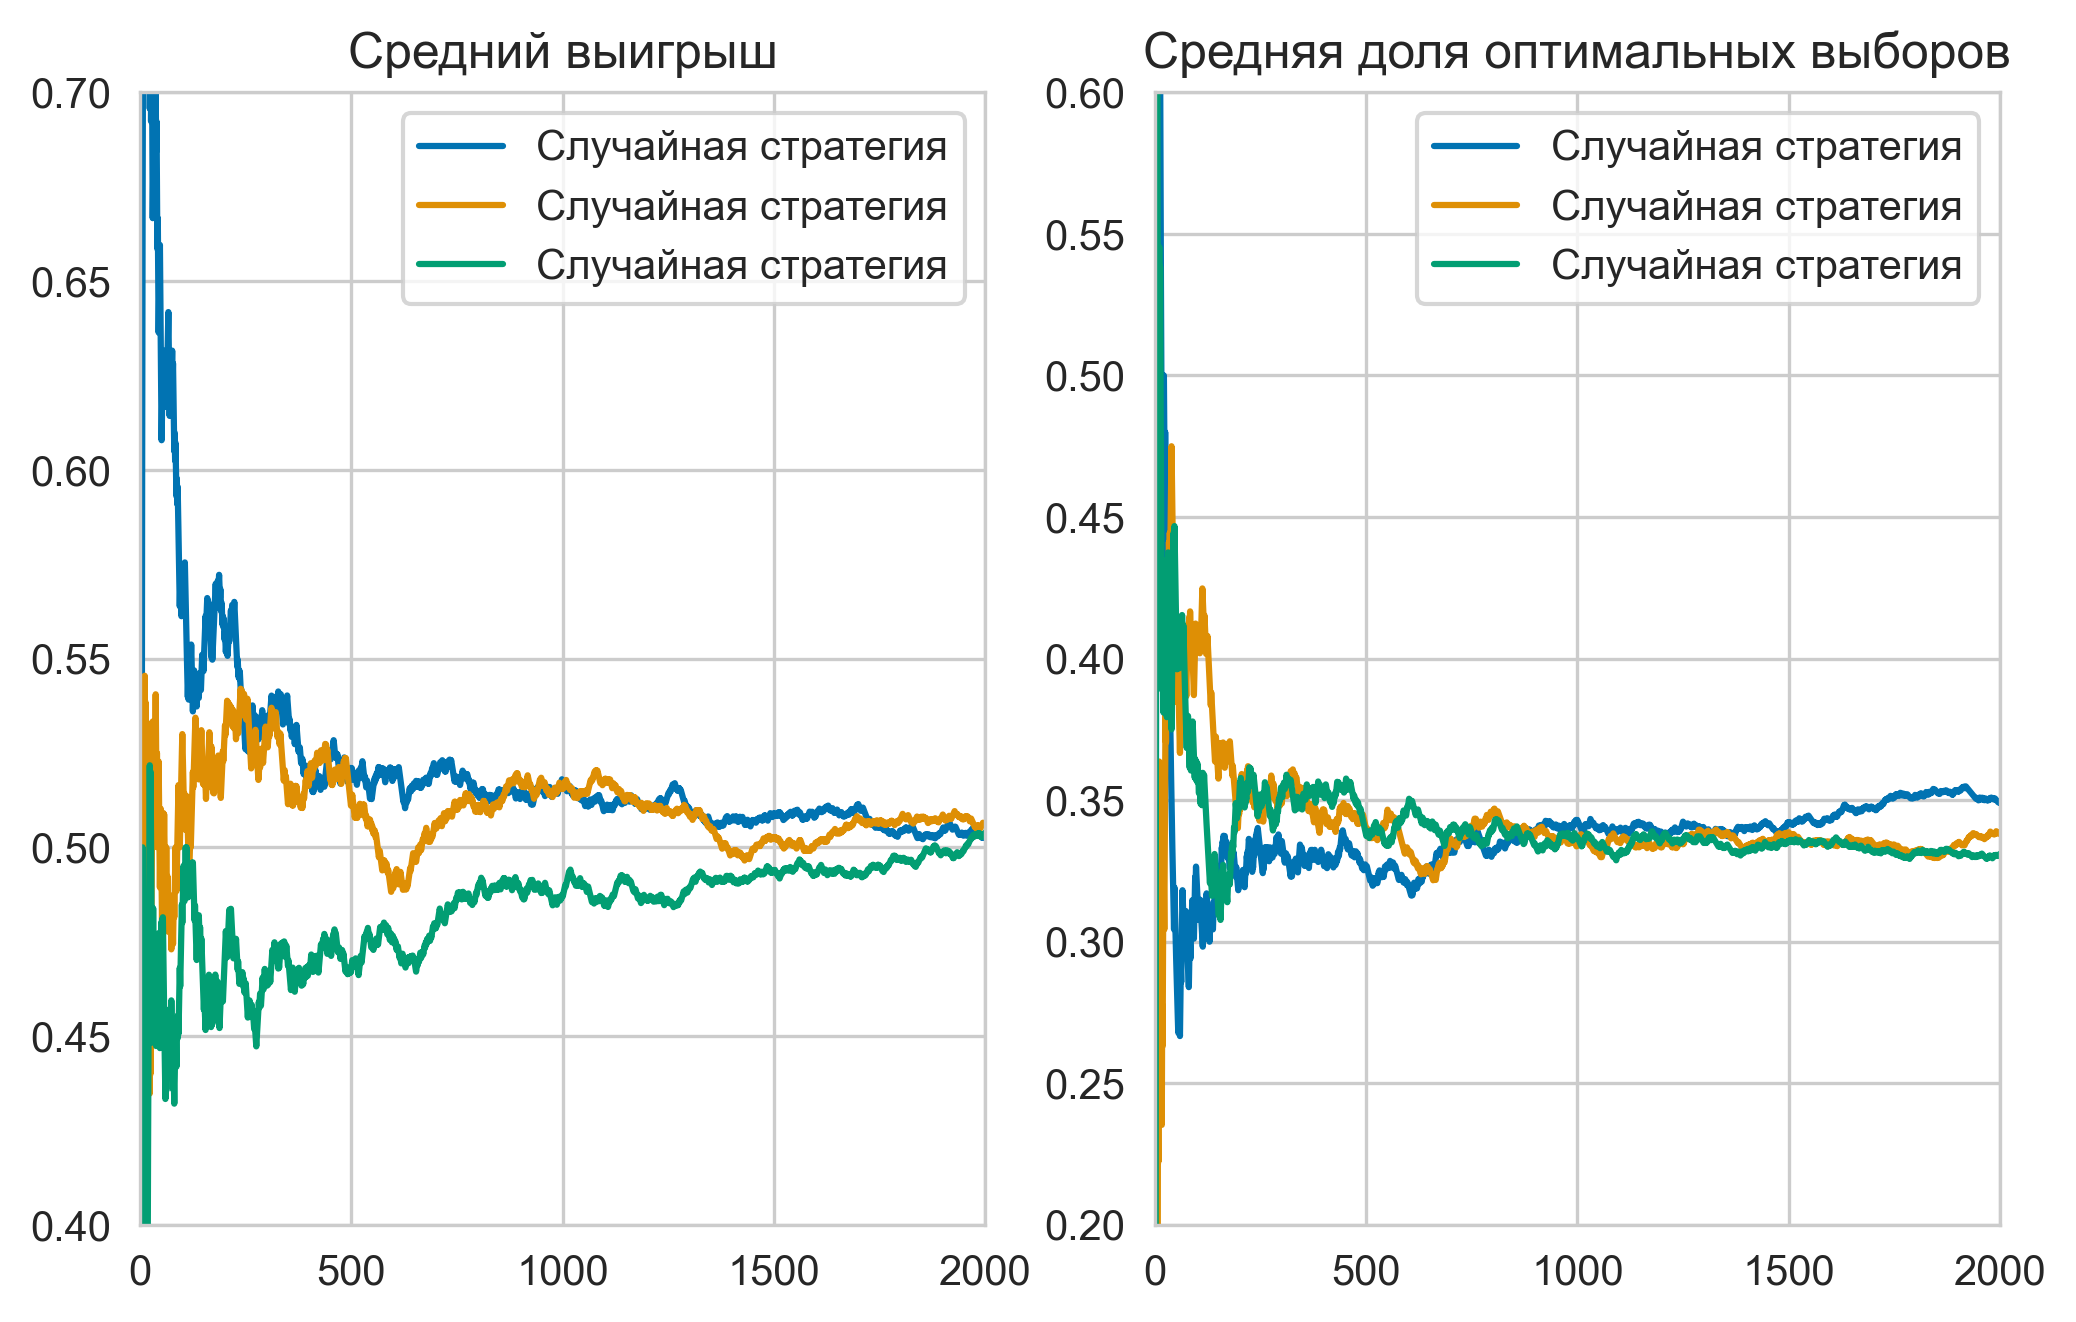

In [6]:
n_bandits = 3
p_bandits = np.array([0.3, 0.55, 0.65])
m_bandits = np.array([0.5, 1., 1.5])
n_steps = 2000

bandits = [Bandit(n_bandits, "Случайная стратегия"), Bandit(n_bandits, "Случайная стратегия"), Bandit(n_bandits, "Случайная стратегия")]
run_bandits(bandits, p_bandits, n_step=n_steps)
# run_bandits(bandits, m_bandits, pull=pull_gauss_np, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, 2, figsize=(8, 5))
ax[0].set_ylim((0.4, 0.7))
ax[1].set_ylim((0.2, 0.6))

(0.25, 0.45)

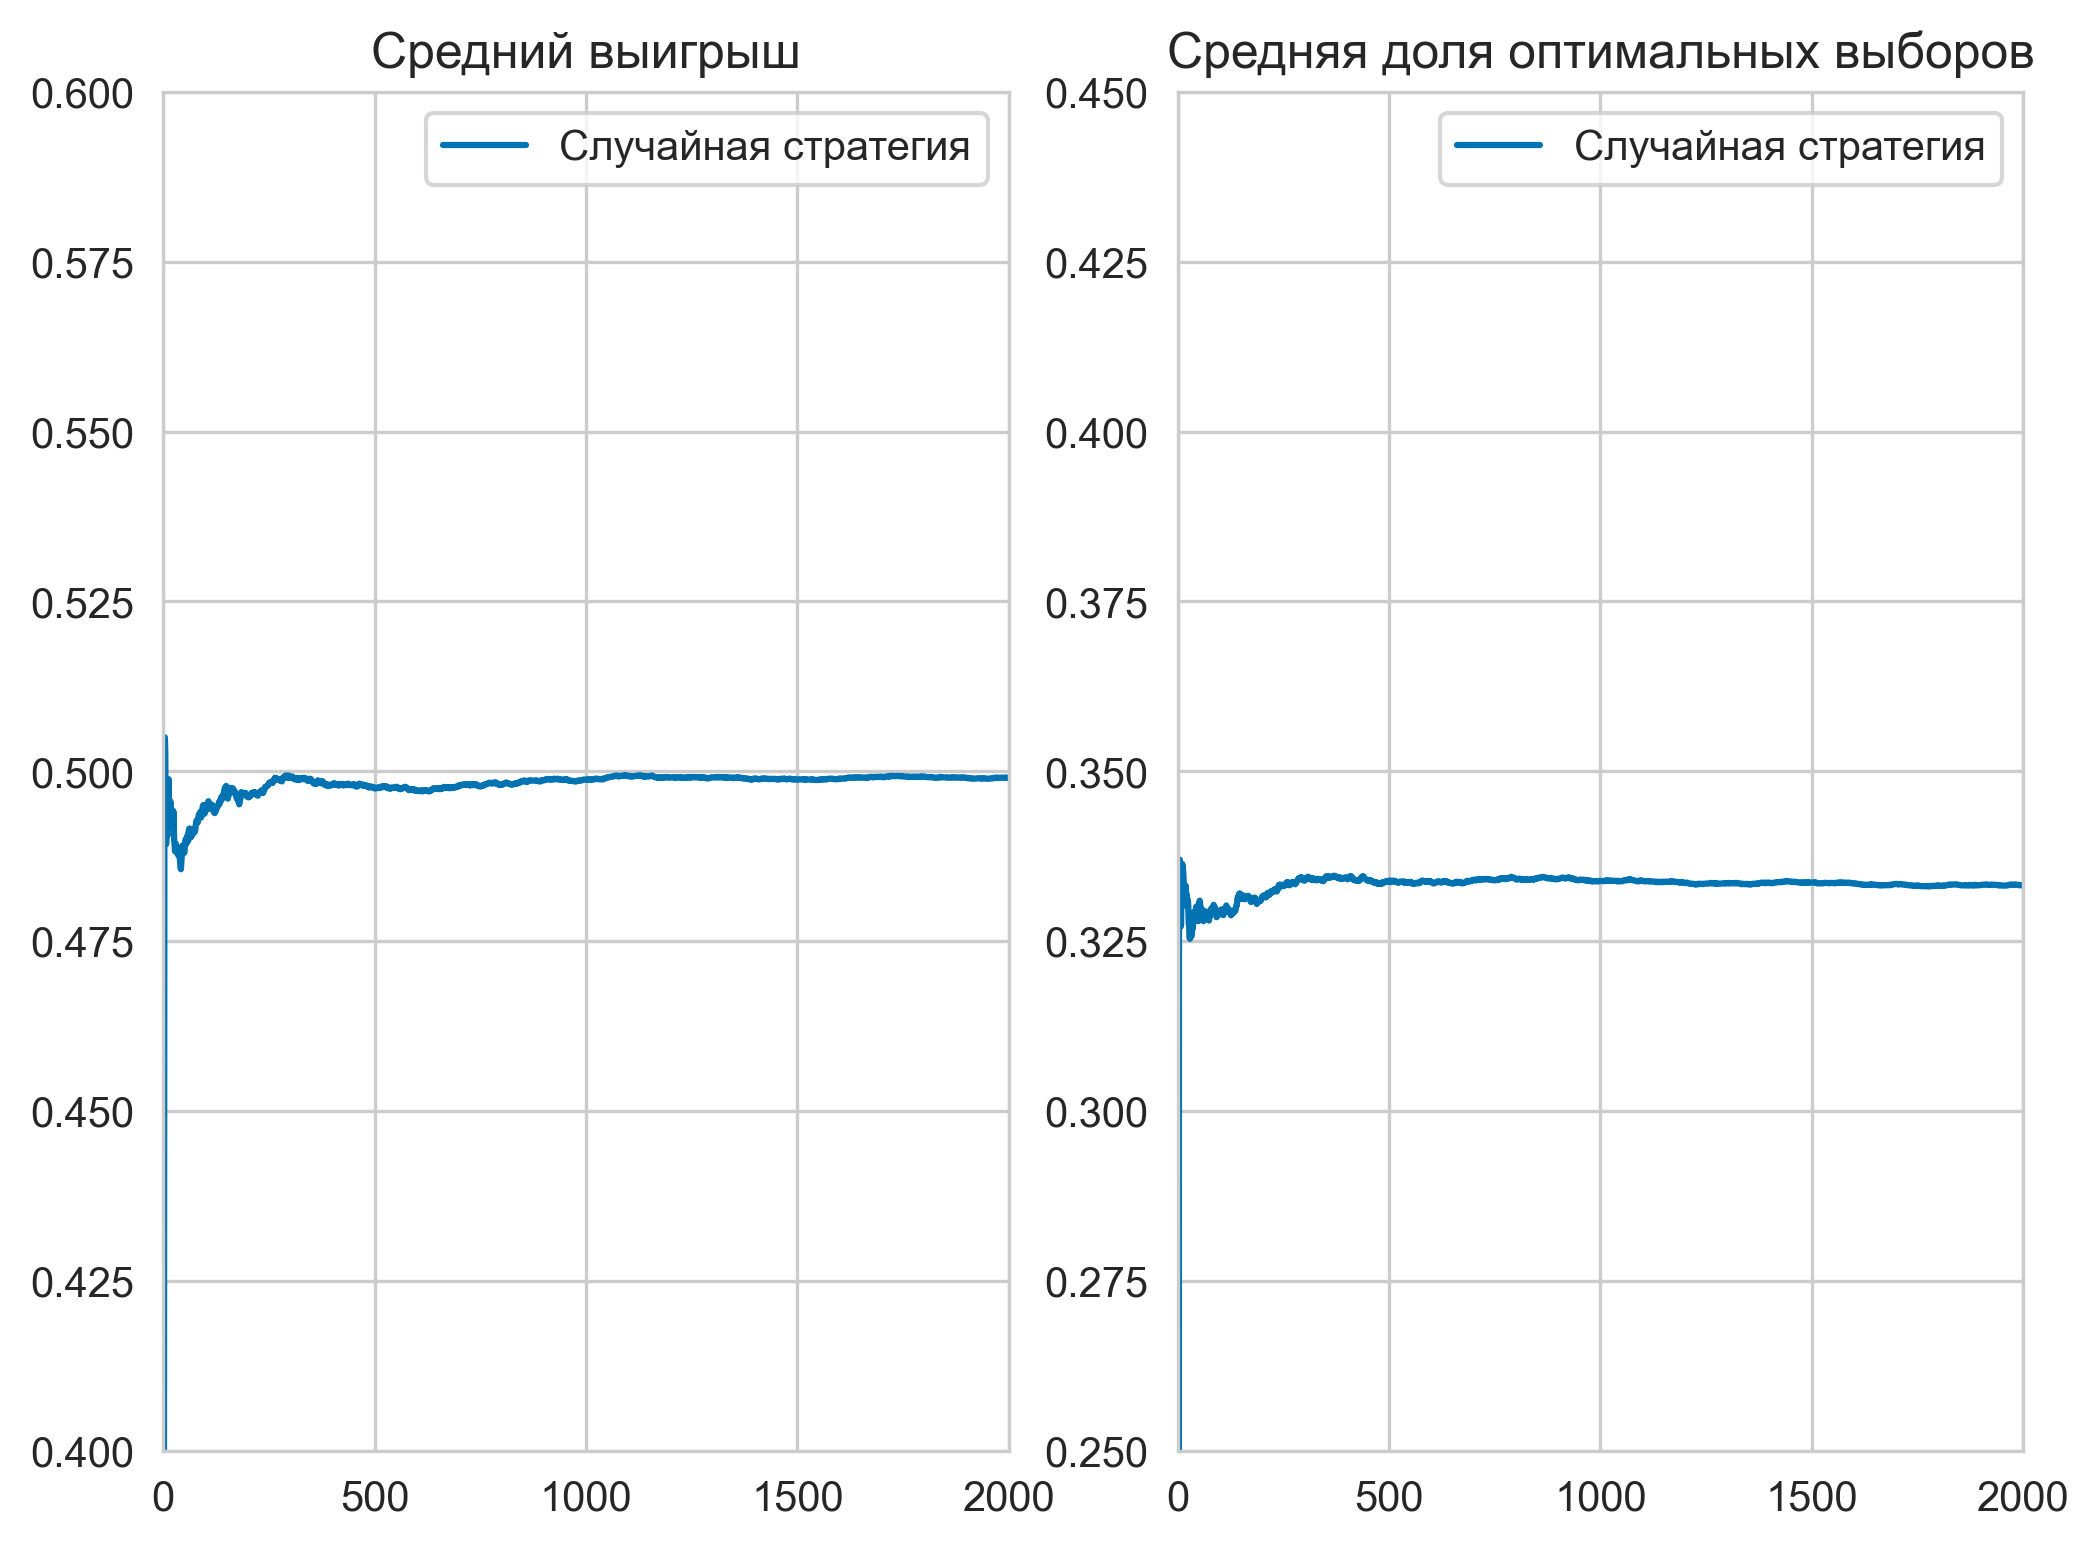

In [7]:
p_bandits = np.array([0.3, 0.55, 0.65])
n_bandits = len(p_bandits)
n_steps = 1000
bandits = [ Bandit(n_bandits, "Случайная стратегия") for _ in range(200) ]
run_bandits(bandits, p_bandits, n_step=2000)
fig, ax = plot_average_over_bandits([bandits], 2, figsize=(8, 6))
ax[0].set_ylim((0.4, 0.6))
ax[1].set_ylim((0.25, 0.45))

In [8]:
class GreedyBandit(Bandit):
    def internal_next_arm(self):
        return np.argmax( np.true_divide( self.w, self.n ) )

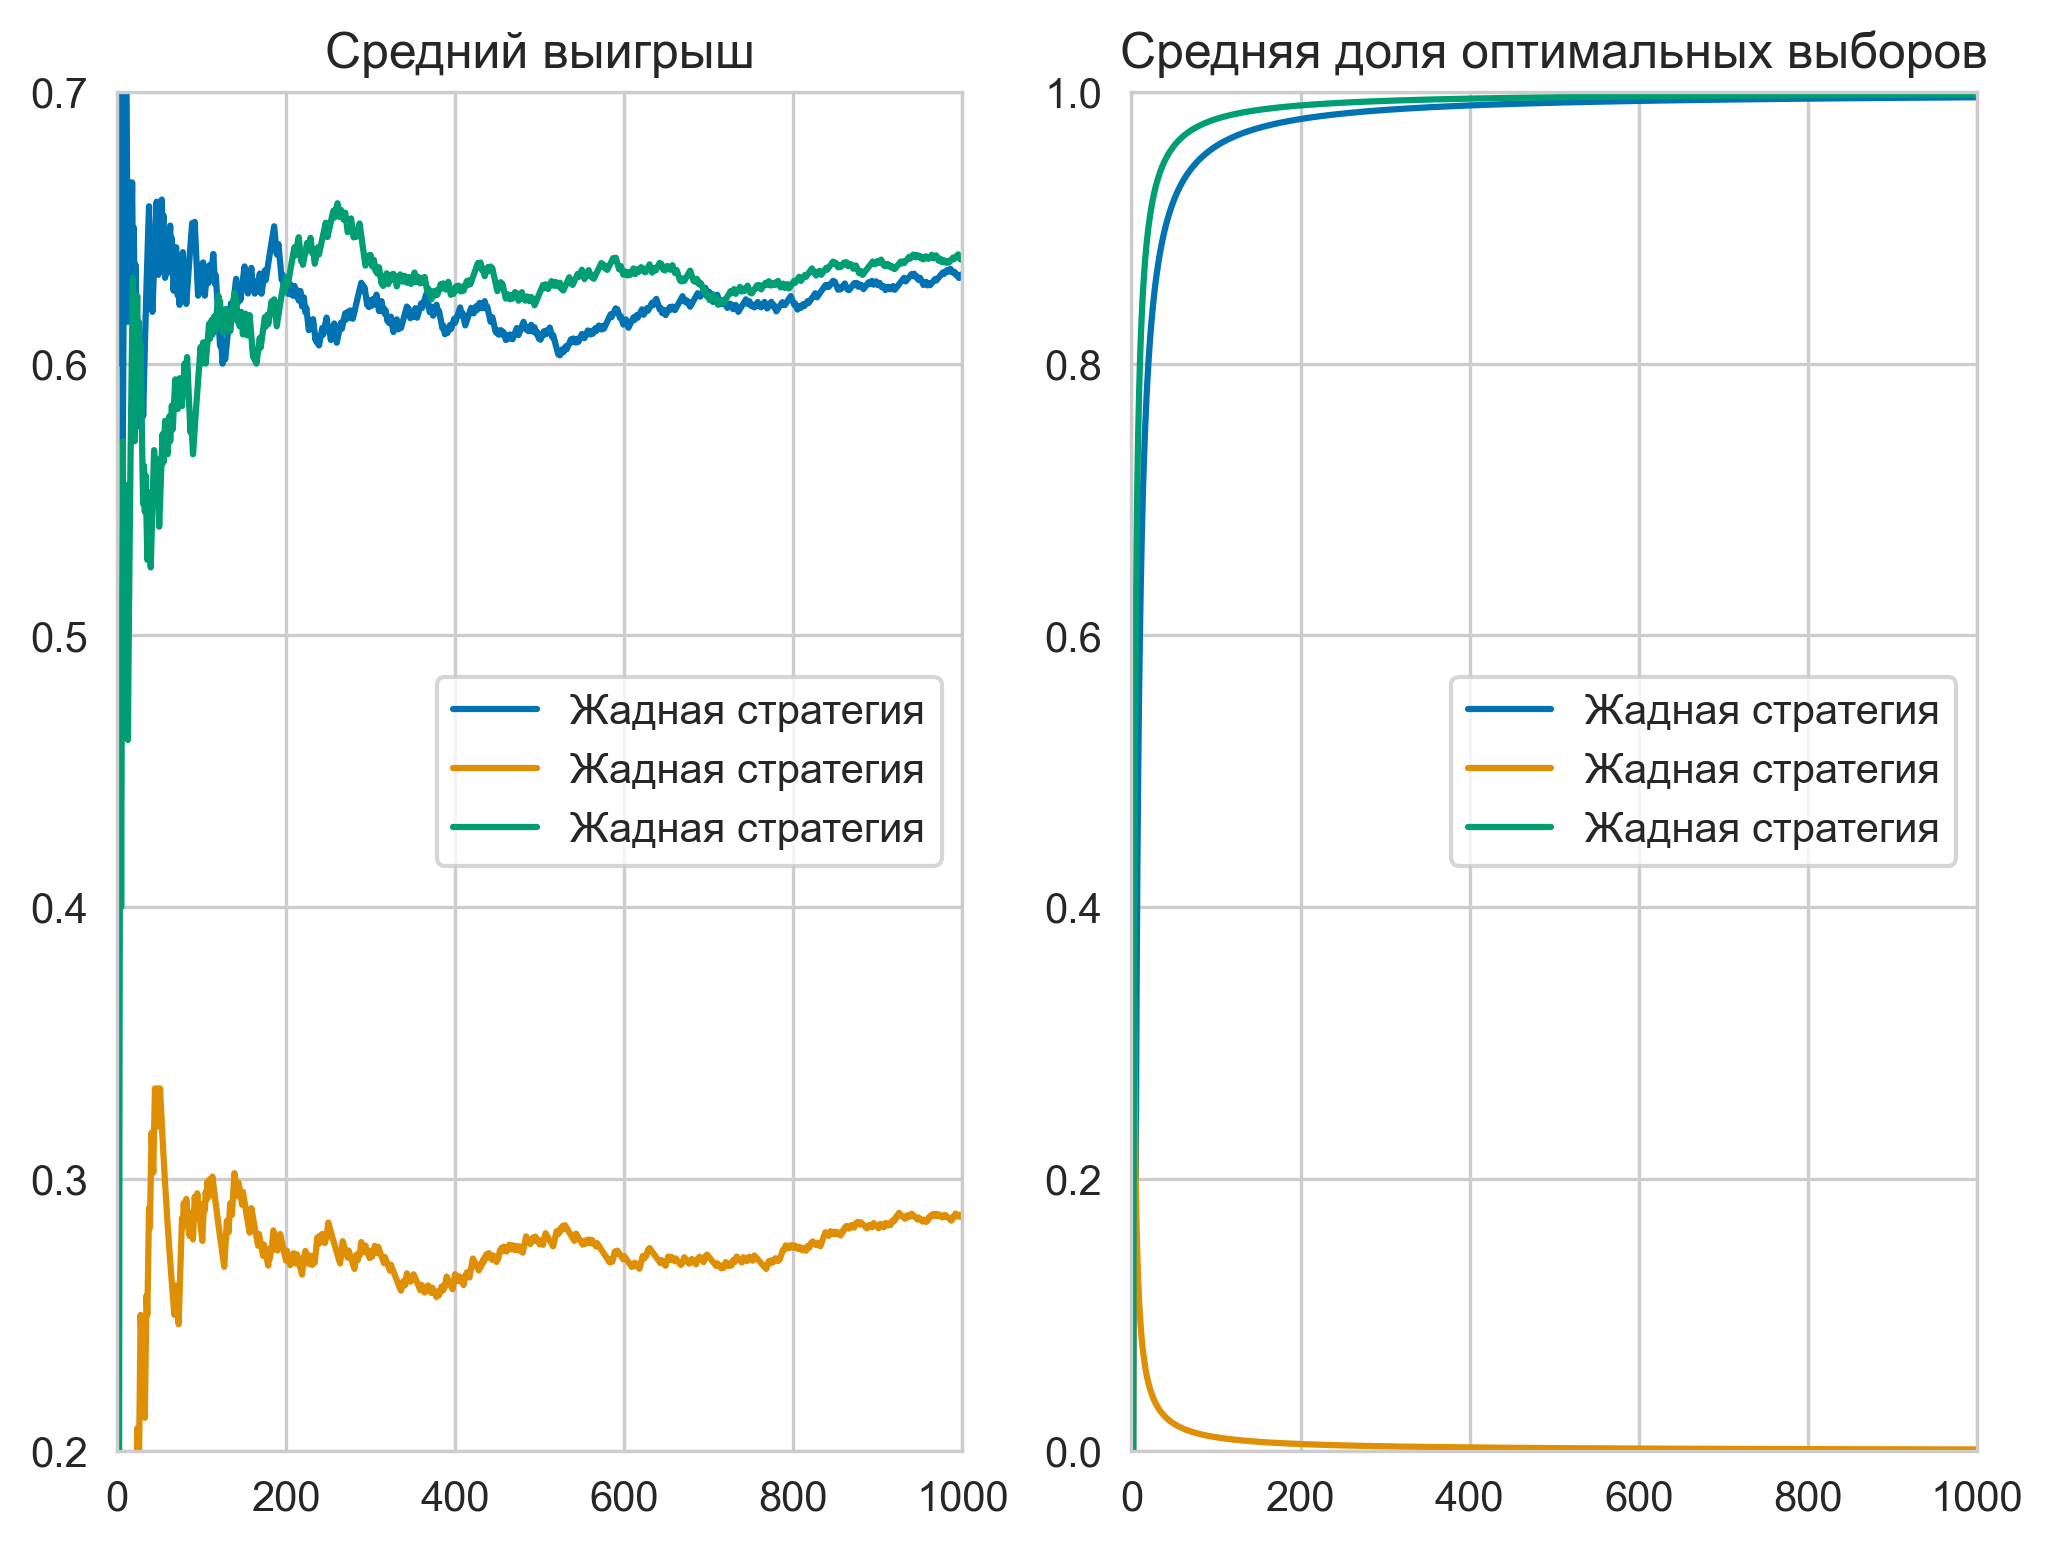

In [9]:
p_bandits = np.array([0.3, 0.55, 0.65])
n_bandits = len(p_bandits)
n_steps = 1000

bandits = [GreedyBandit(n_bandits, "Жадная стратегия"), GreedyBandit(n_bandits, "Жадная стратегия"), GreedyBandit(n_bandits, "Жадная стратегия")]
run_bandits(bandits, p_bandits, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, 2, figsize=(8, 6))
ax[0].set_ylim((0.2, 0.7))
ax[1].set_ylim((0, 1))
ax[0].legend(loc="center right")
ax[1].legend(loc="center right")
# fig.savefig(output_directory + 'rl_bandits2.pdf', bbox_inches='tight')

In [10]:
bandits[0].n

array([  2,   2, 996])

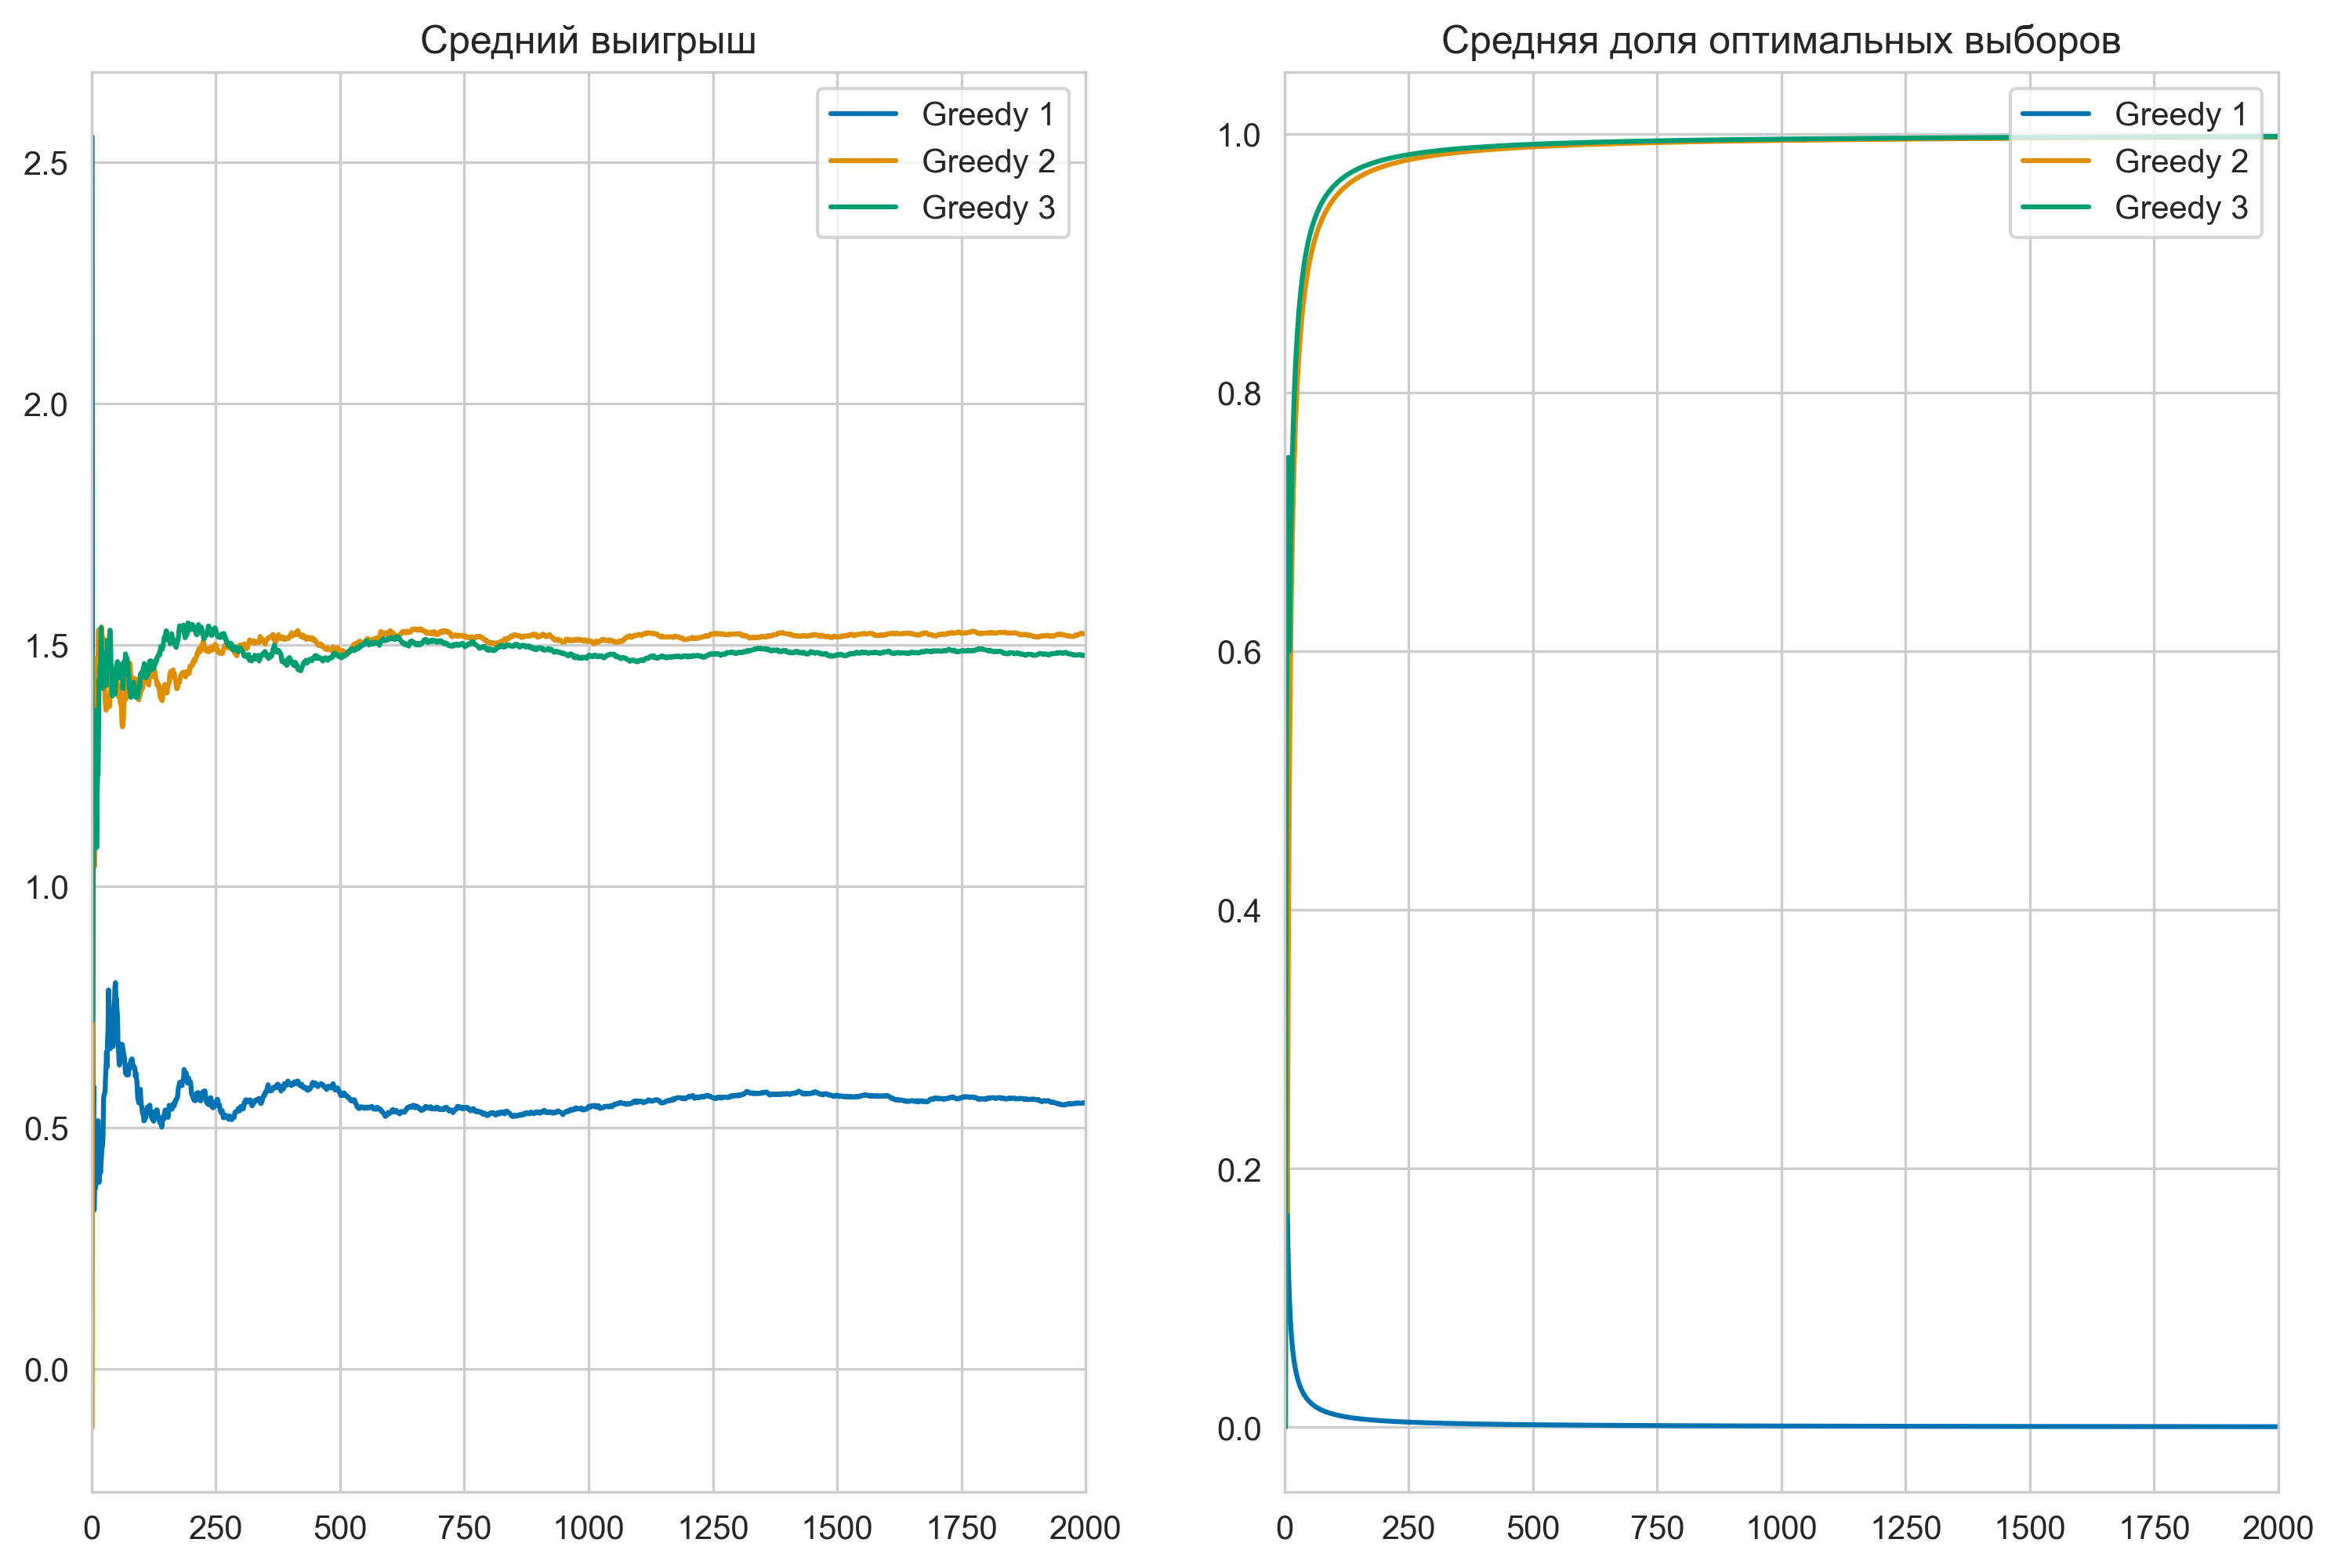

In [11]:
m_bandits = np.array([0.5, 1., 1.5])
n_bandits = len(m_bandits)
n_steps =  2000

bandits = [GreedyBandit(n_bandits, "Greedy 1"), GreedyBandit(n_bandits, "Greedy 2"), GreedyBandit(n_bandits, "Greedy 3")]
run_bandits(bandits, m_bandits, pull=pull_gauss_np, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, 2)

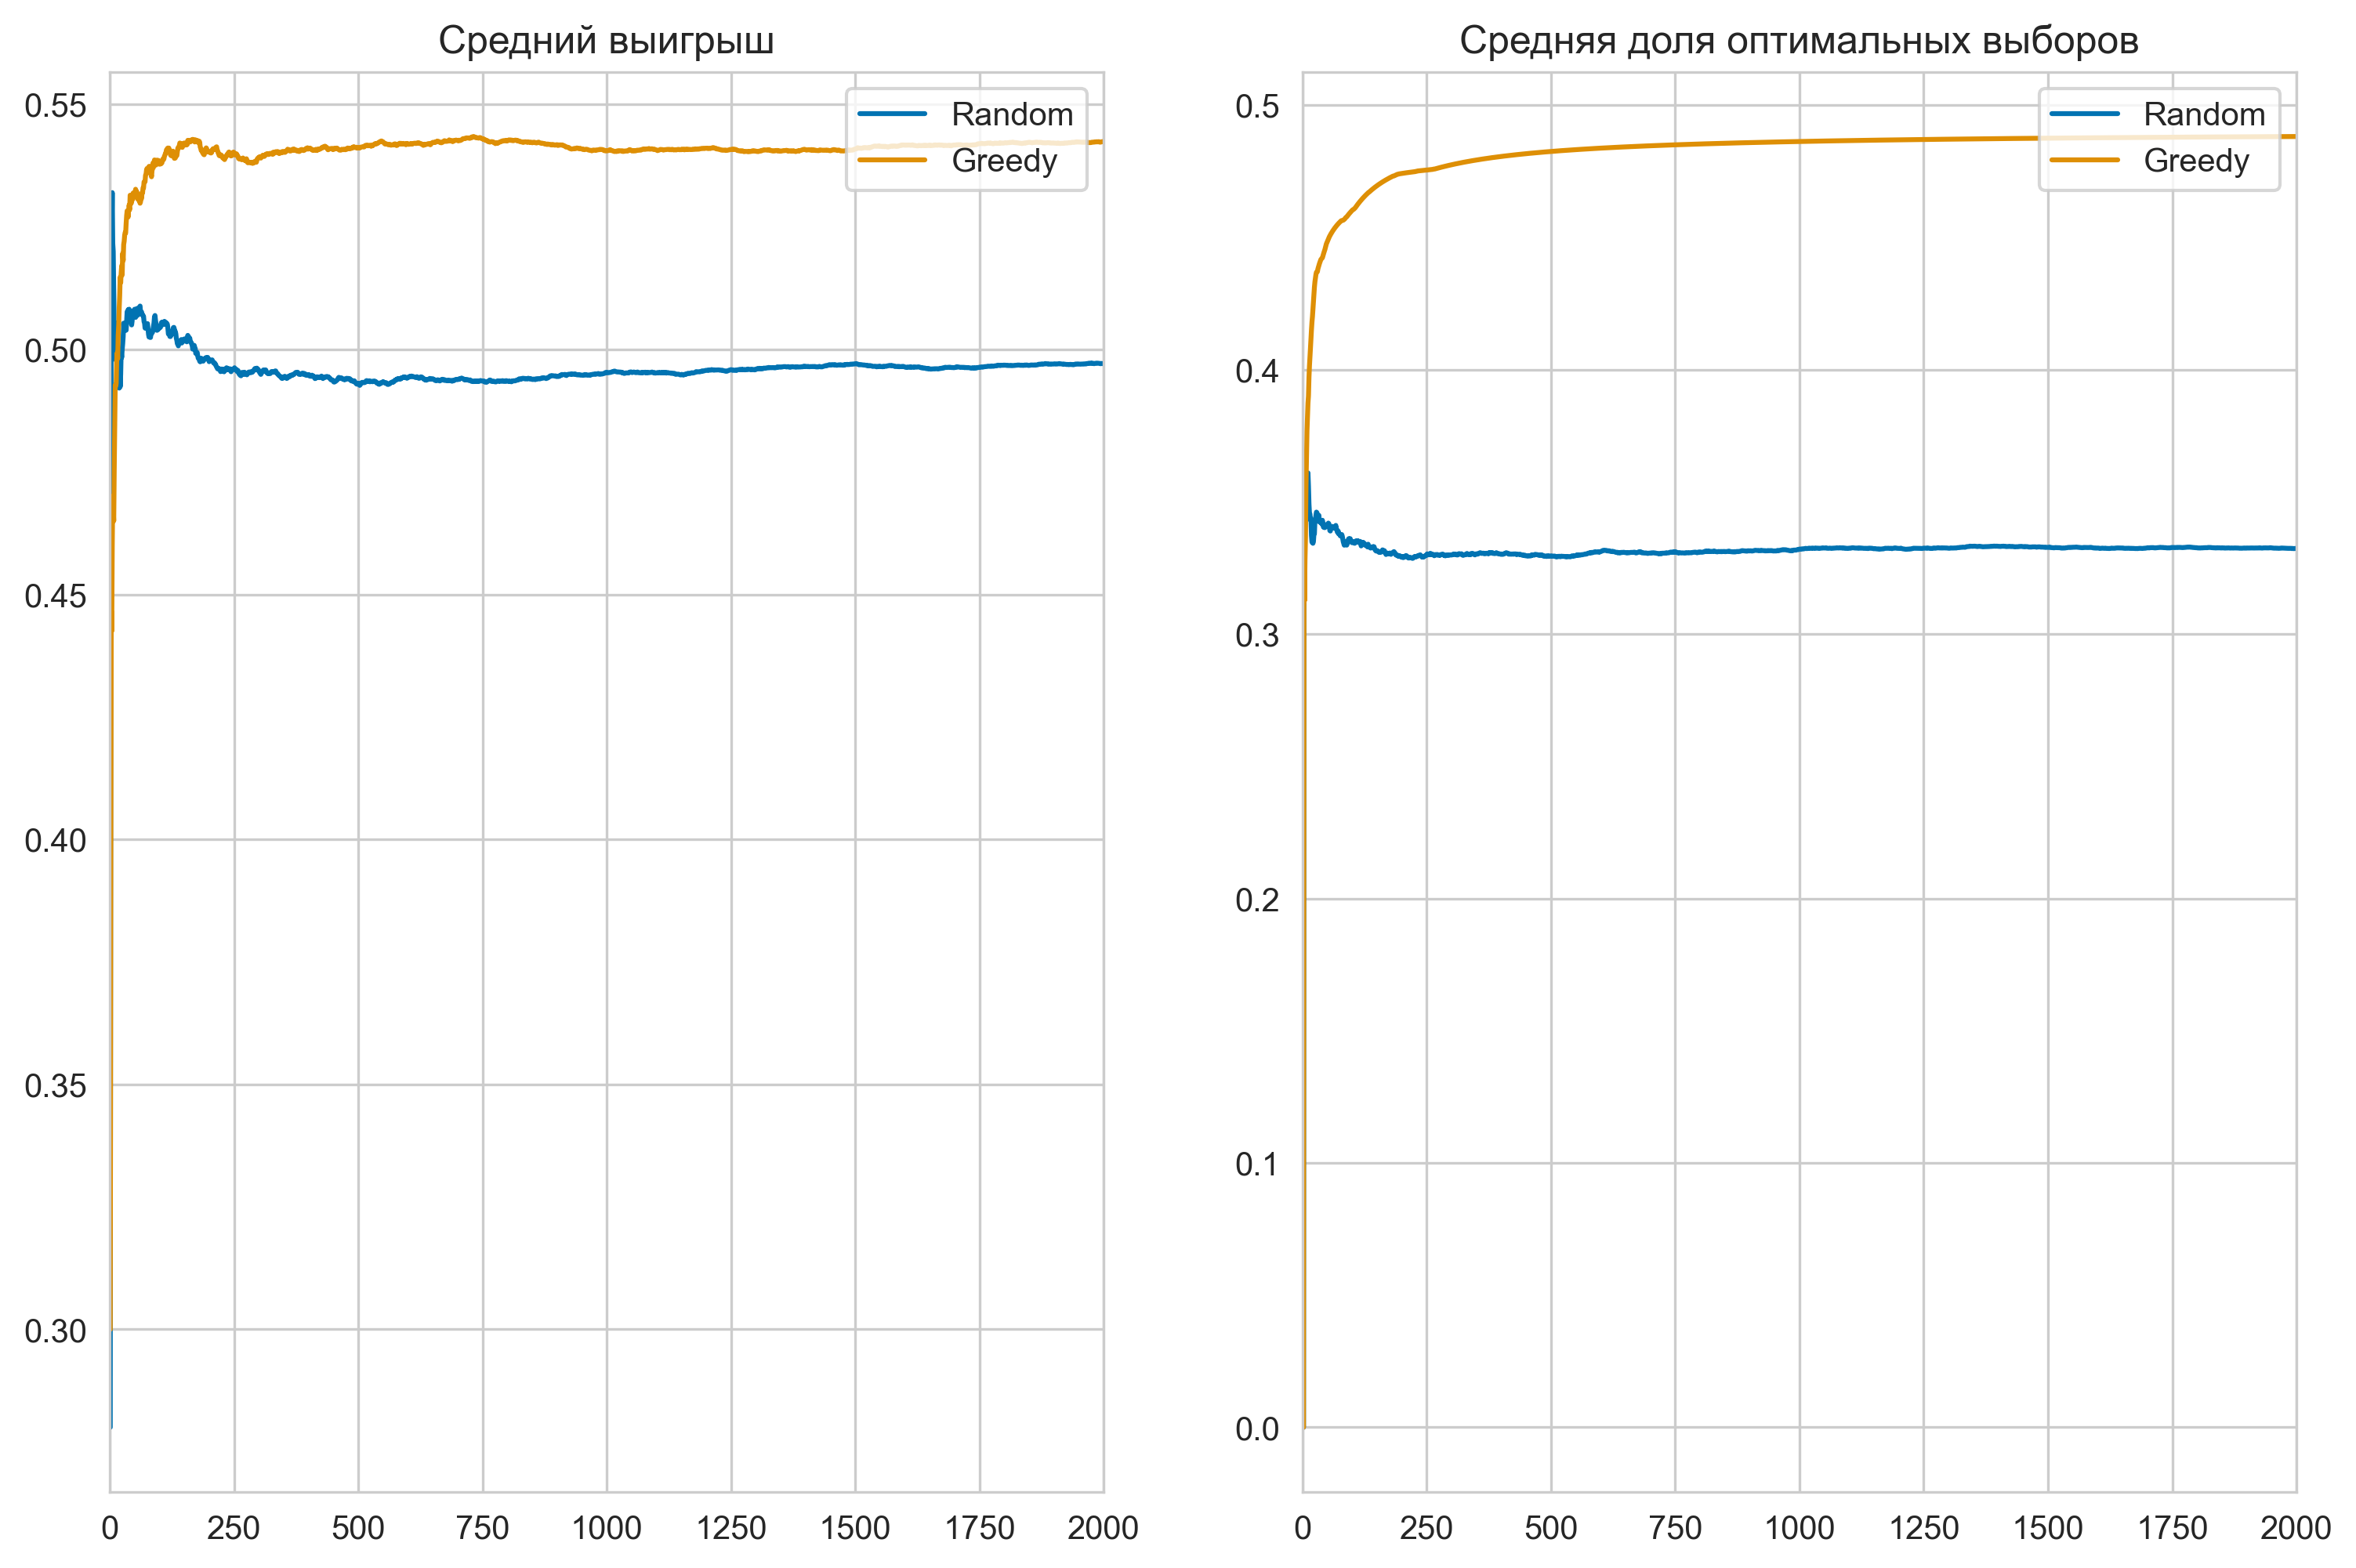

In [12]:
p_bandits = np.array([0.3, 0.55, 0.65])
n_bandits = len(p_bandits)
n_steps = 1000

n_random, n_greedy = 100, 100

bandits = [ Bandit(n_bandits, "Random") for _ in range(n_random) ] + [ GreedyBandit(n_bandits, "Greedy") for _ in range(n_greedy) ]
run_bandits(bandits, p_bandits, n_step=2000)
fig, axs = plot_average_over_bandits([bandits[:n_random], bandits[n_random:n_random+n_greedy]], 2)

In [13]:
class EpsGreedyBandit(Bandit):
    def __init__(self, num, label, eps=0.1):
        super().__init__(num, label)
        self.eps = eps

    def internal_next_arm(self):
        if np.random.rand() > self.eps:
            return np.argmax( np.true_divide( self.w, self.n ) )
        else:
            return np.random.randint(self.num)

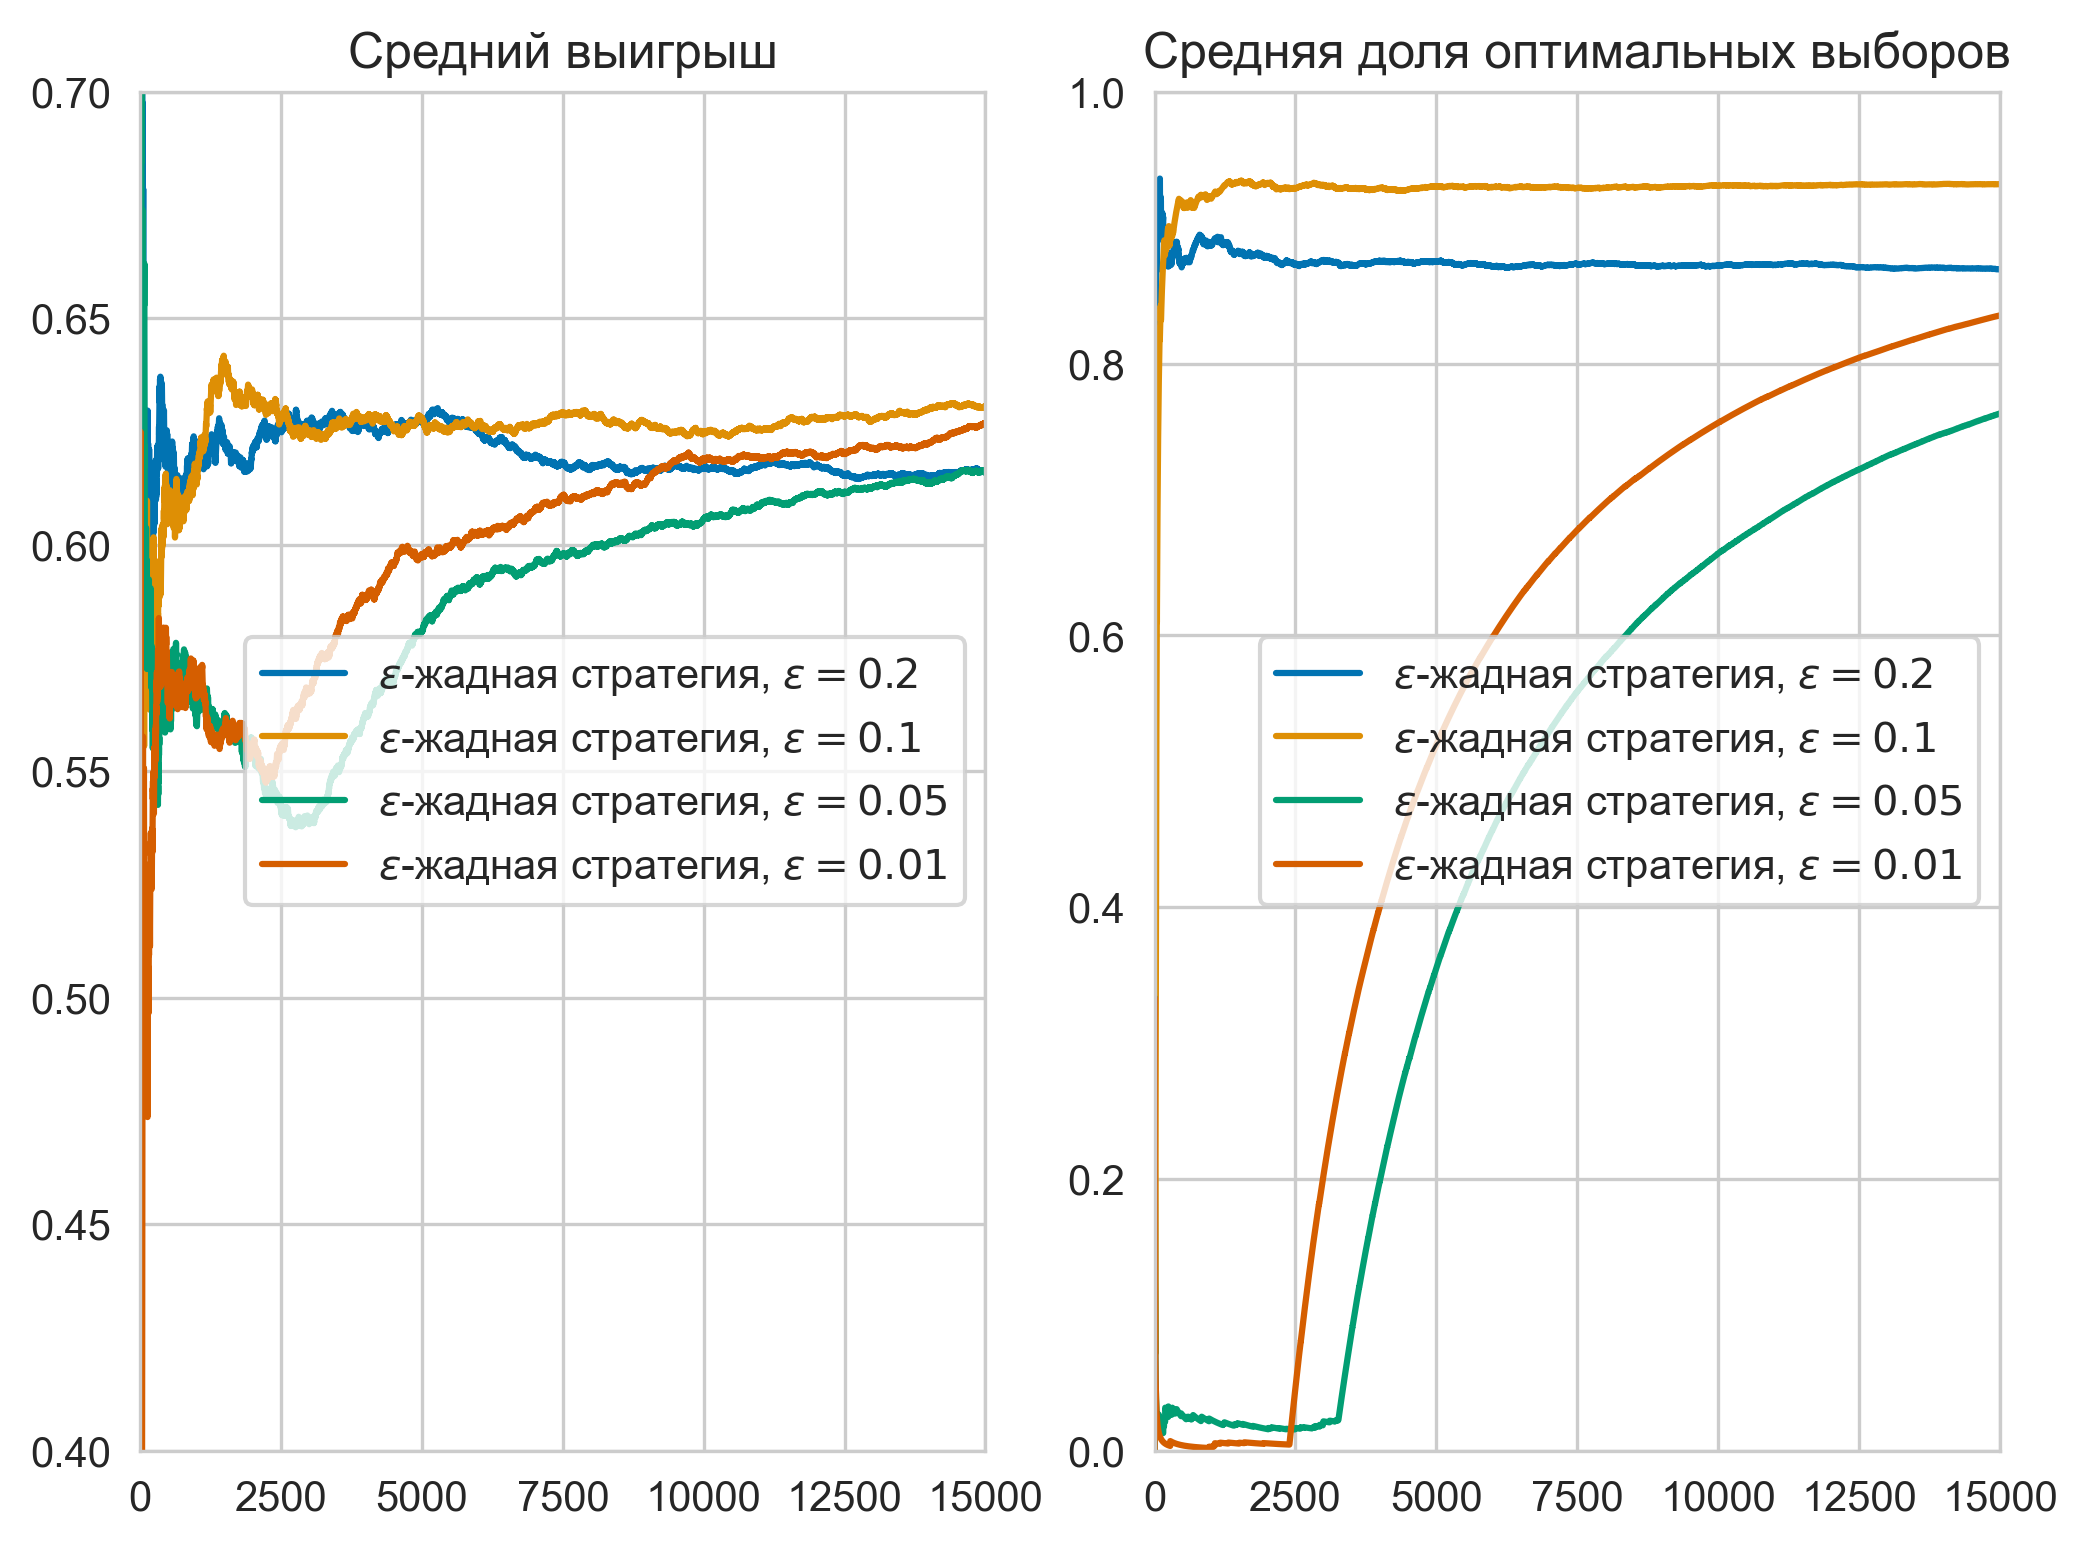

In [14]:
p_bandits = np.array([0.3, 0.55, 0.65])
best_arm = np.argmax(p_bandits)
n_bandits = len(p_bandits)
n_steps = 15000

# bandits = [GreedyBandit(n_bandits, "Greedy"), EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.1$", 0.1), EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.01$", 0.01)]
bandits = [EpsGreedyBandit(n_bandits, "$\\epsilon$-жадная стратегия, $\\epsilon=0.2$", 0.2), EpsGreedyBandit(n_bandits, "$\\epsilon$-жадная стратегия, $\\epsilon=0.1$", 0.1), EpsGreedyBandit(n_bandits, "$\\epsilon$-жадная стратегия, $\\epsilon=0.05$", 0.05), EpsGreedyBandit(n_bandits, "$\\epsilon$-жадная стратегия, $\\epsilon=0.01$", 0.01)]
run_bandits(bandits, p_bandits, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, best_arm, figsize=(8, 6))
ax[0].set_ylim((0.4, 0.7))
ax[1].set_ylim((0, 1))
ax[0].legend(loc="center right")
ax[1].legend(loc="center right")

# fig.savefig(output_directory + 'rl_bandits3.pdf', bbox_inches='tight')

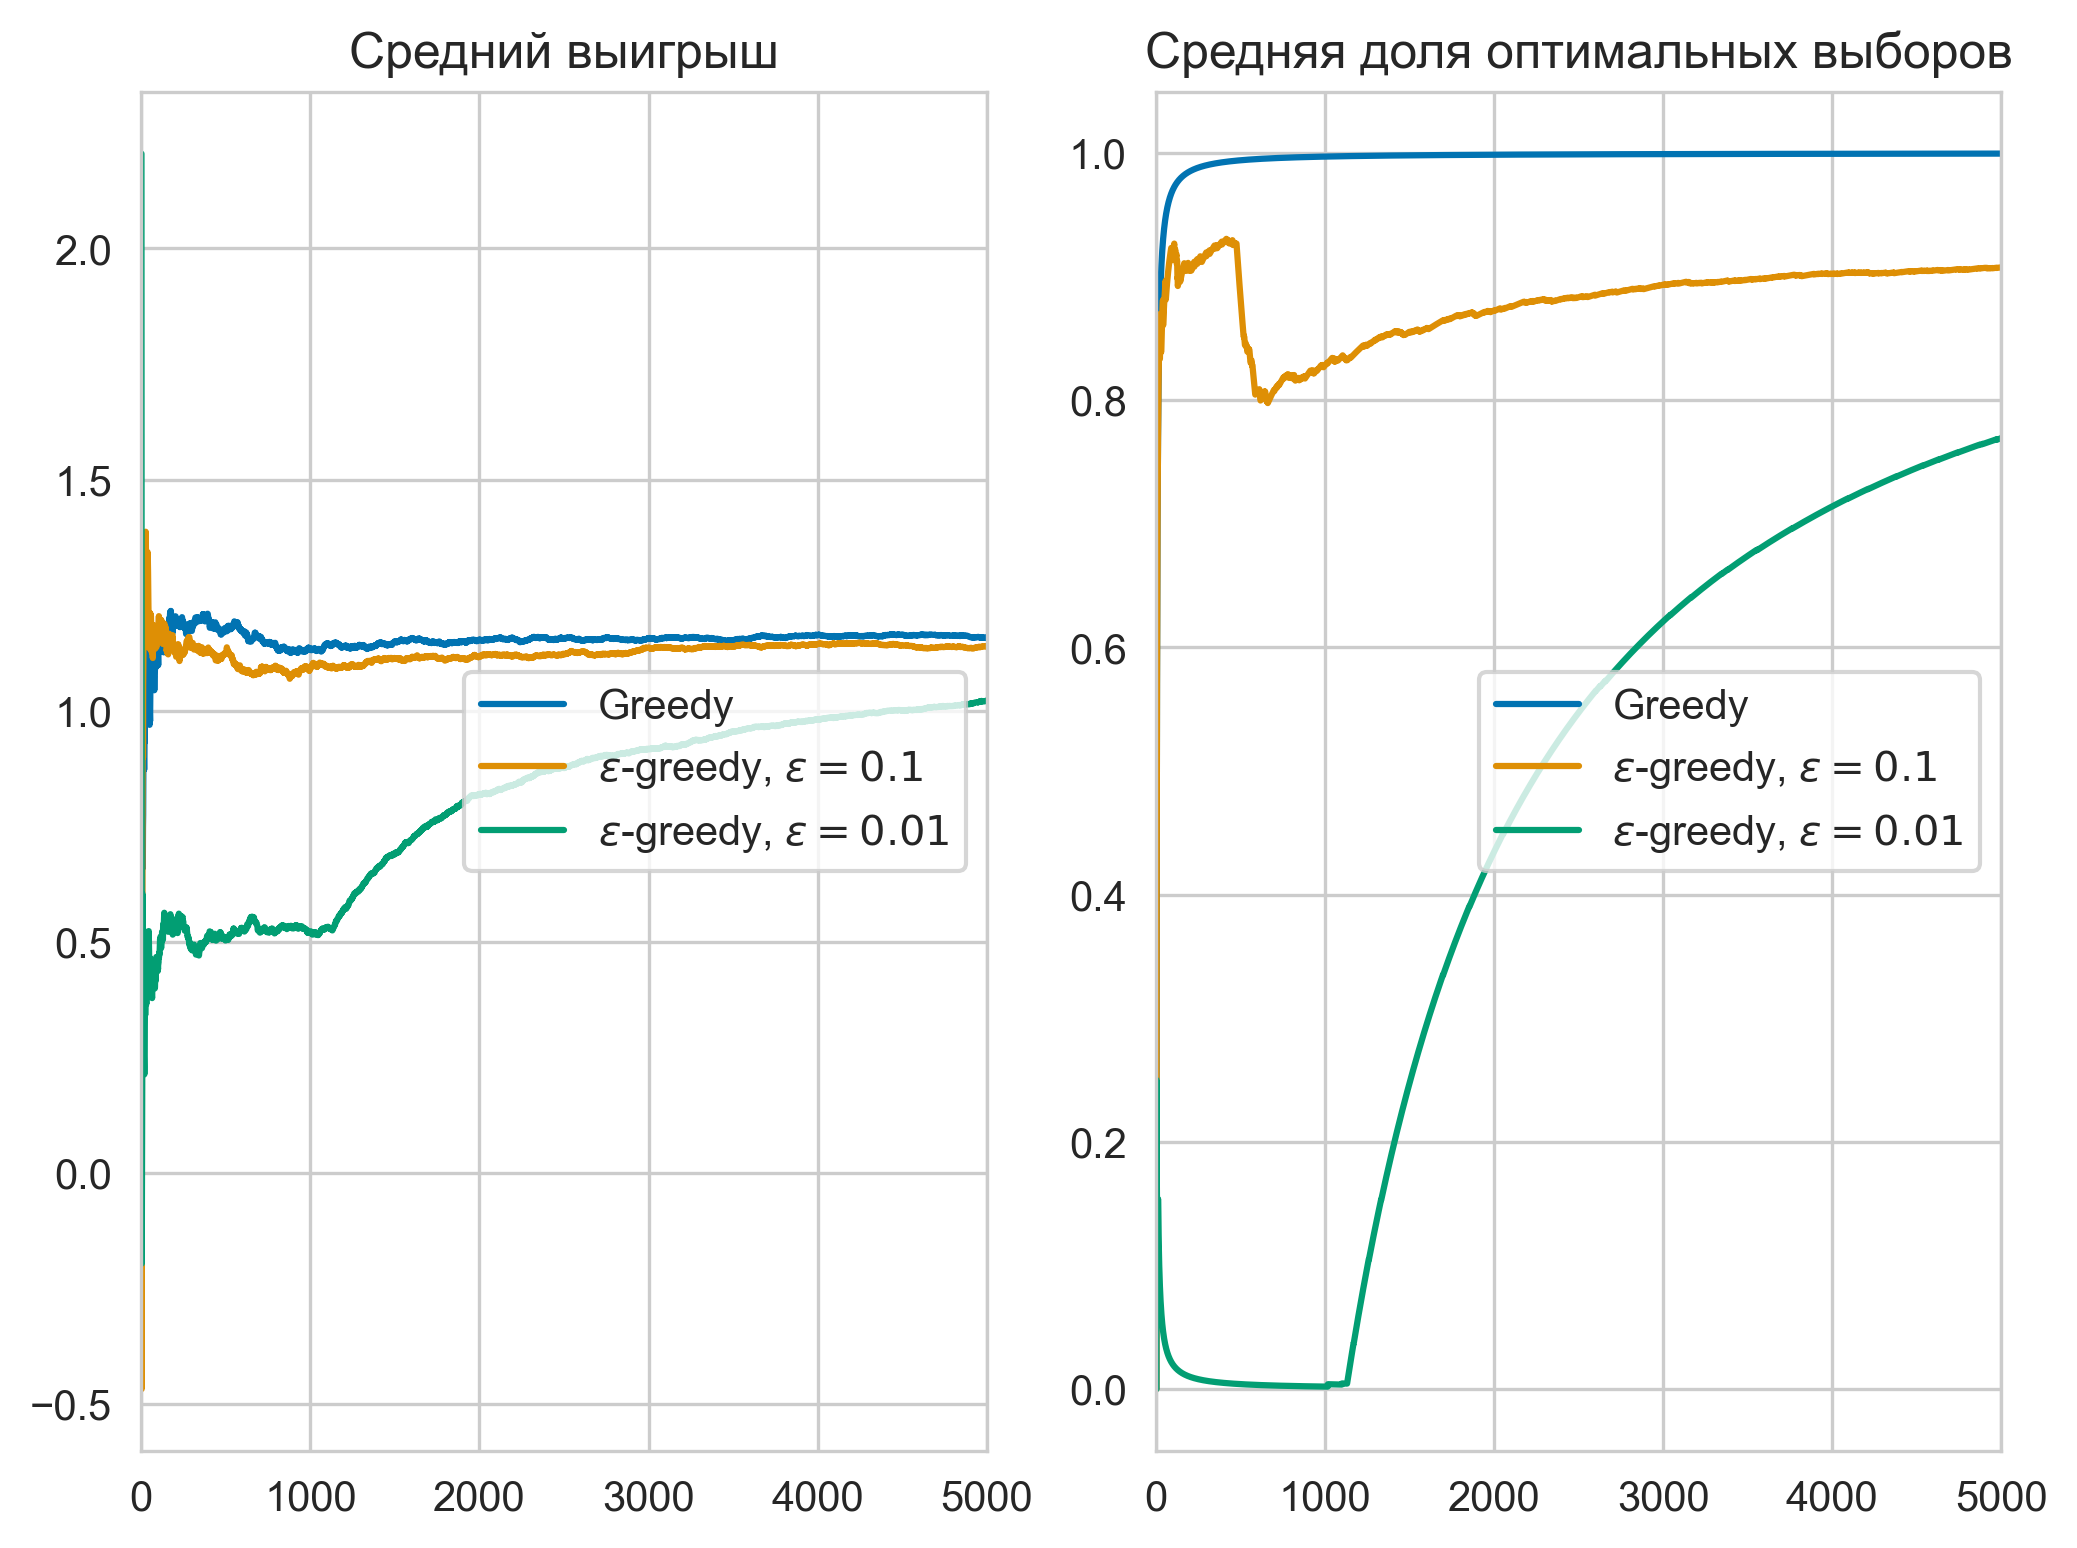

In [15]:
m_bandits = np.array([0.5, 0.75, 1.0, 1.15])
best_arm = np.argmax(m_bandits)
n_bandits = len(m_bandits)
n_steps = 5000

bandits = [GreedyBandit(n_bandits, "Greedy"), EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.1$", 0.1), EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.01$", 0.01)]
run_bandits(bandits, m_bandits, pull=pull_gauss_np, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, best_arm, figsize=(8,6))
ax[0].legend(loc="center right")
ax[1].legend(loc="center right")

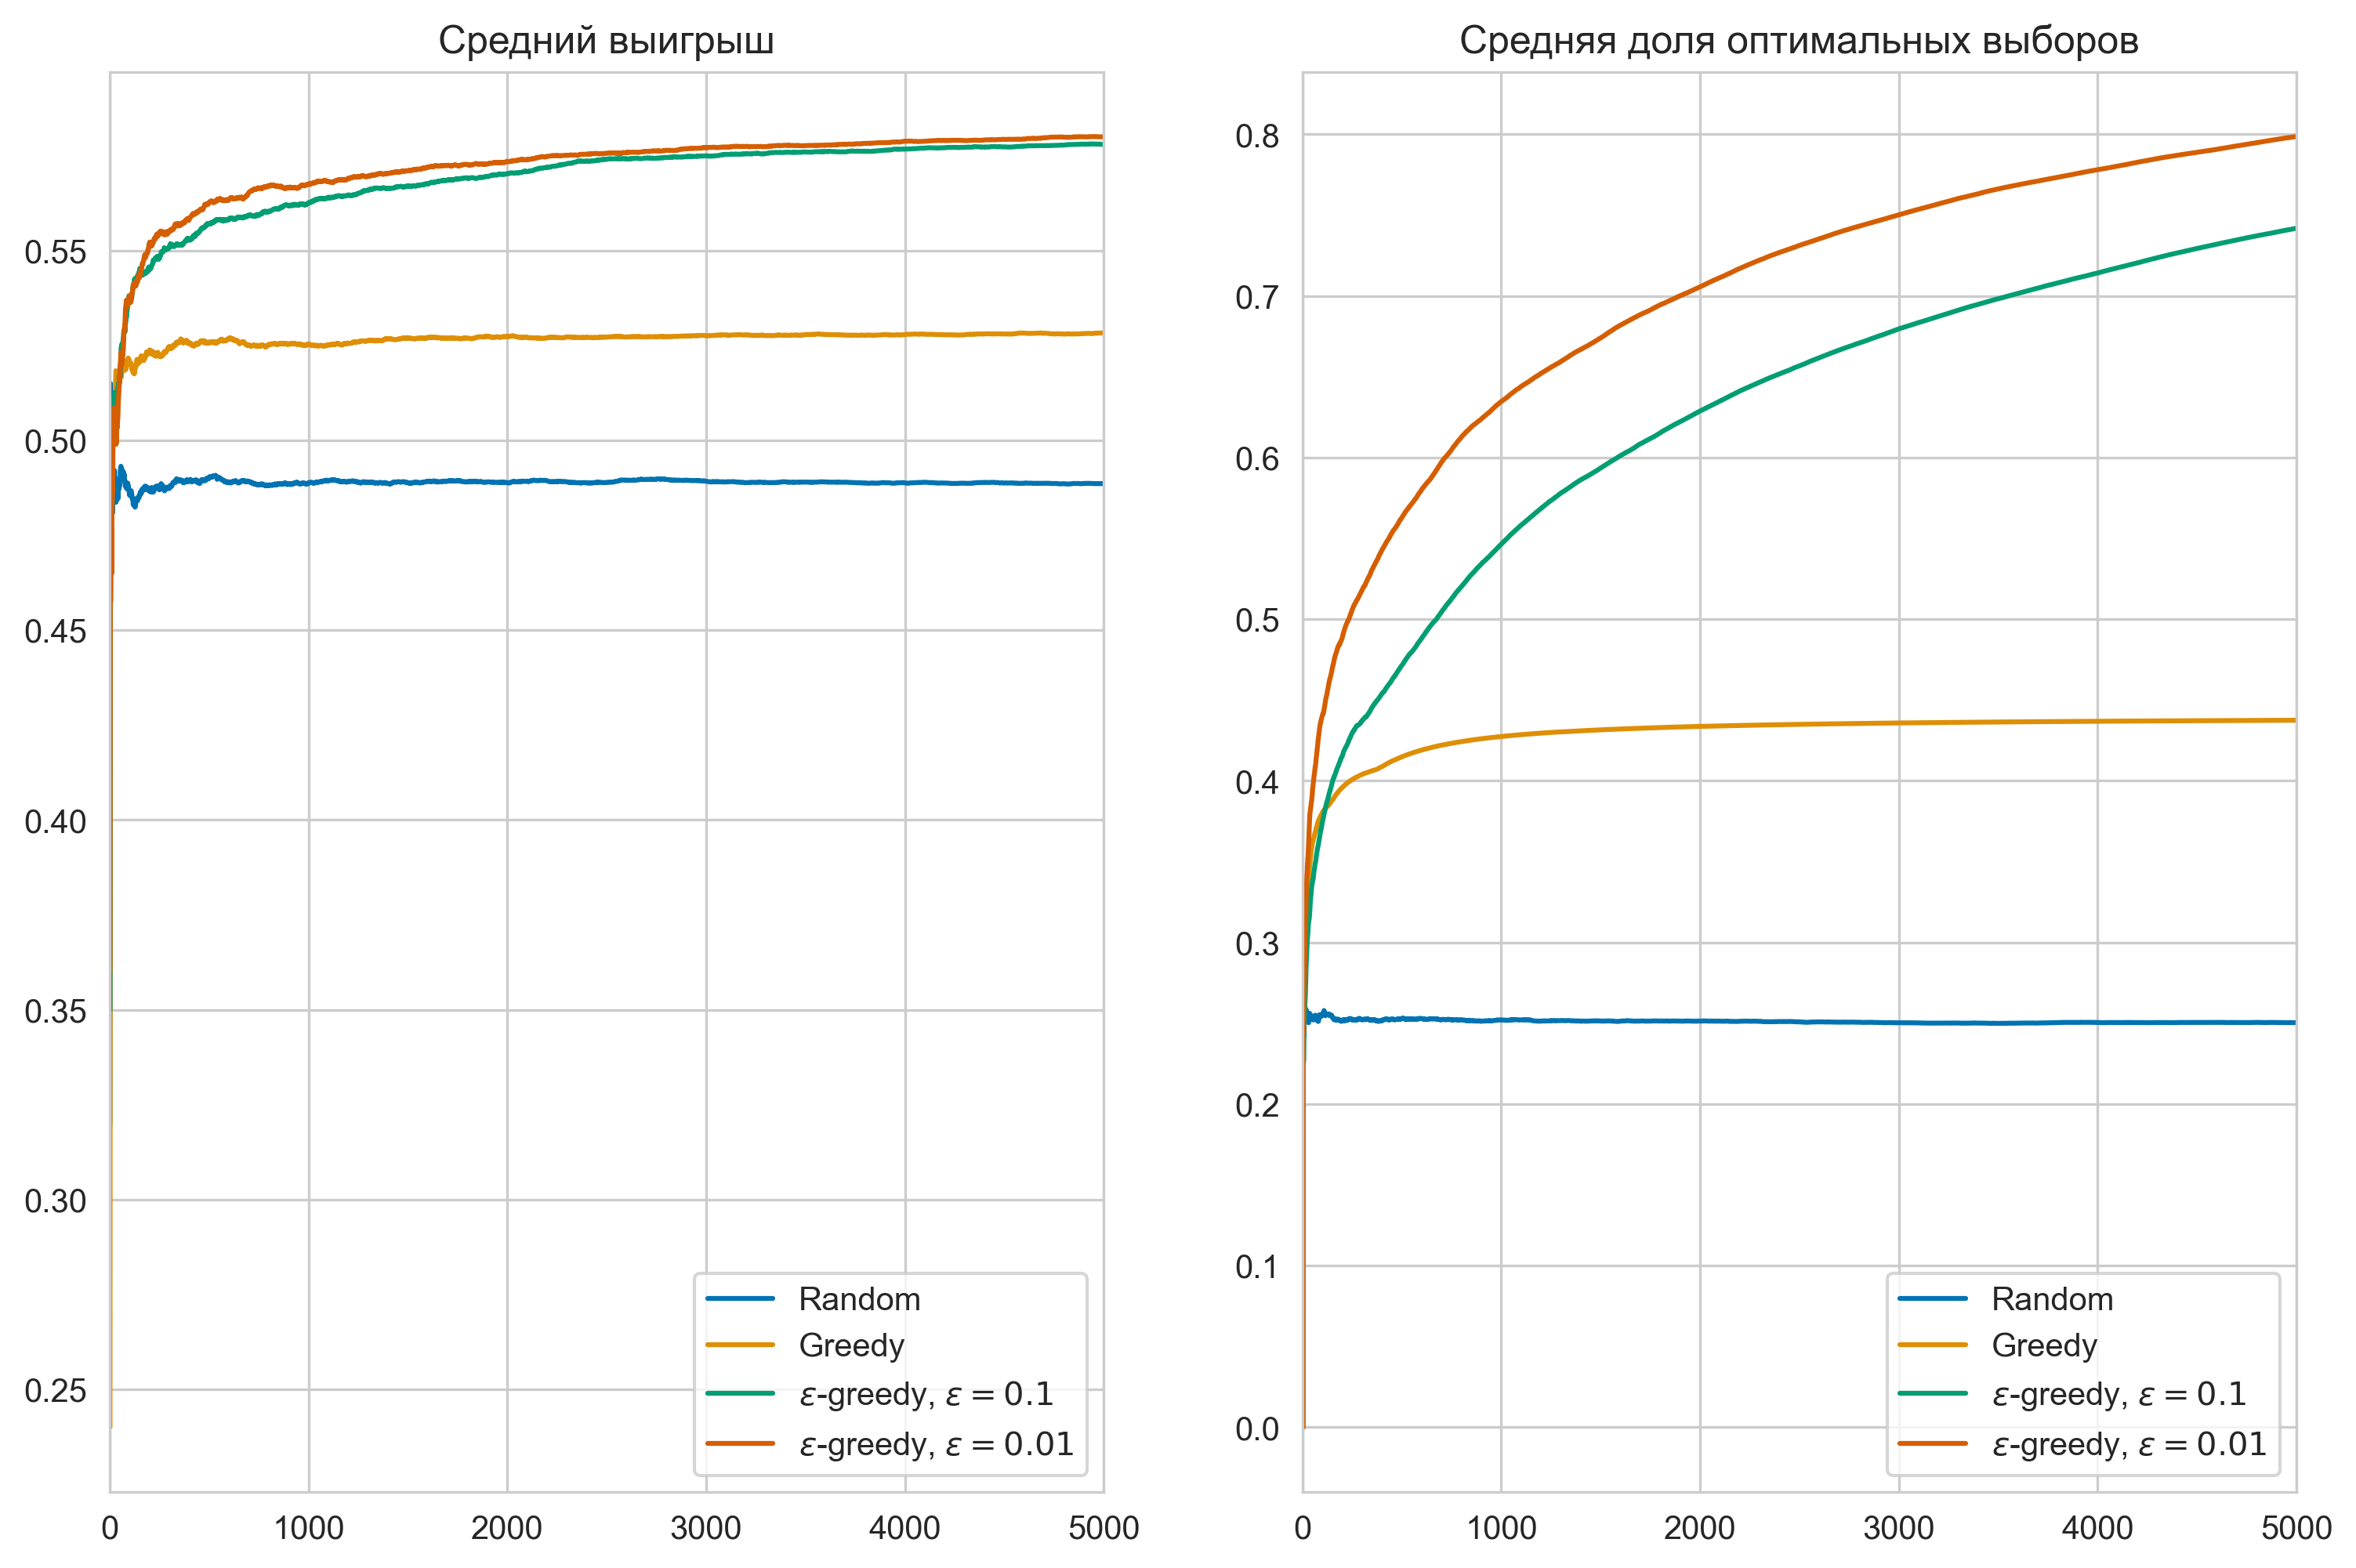

In [16]:
p_bandits = np.array([0.3, 0.5, 0.6, 0.55])
n_bandits = len(p_bandits)
best_arm = np.argmax(p_bandits)

n_random, n_greedy, n_epsgreedy, n_epsgreedy2 = 100, 100, 100, 100

bandits = [ Bandit(4, "Random") for _ in range(n_random) ] + \
          [ GreedyBandit(4, "Greedy") for _ in range(n_greedy) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.1$") for _ in range(n_epsgreedy) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.01$") for _ in range(n_epsgreedy2) ]

run_bandits(bandits, p_bandits, n_step=5000)
fig, axs = plot_average_over_bandits([
    bandits[:n_random],
    bandits[n_random:n_random+n_greedy],
    bandits[n_random+n_greedy:n_random+n_greedy+n_epsgreedy],
    bandits[n_random+n_greedy+n_epsgreedy:n_random+n_greedy+n_epsgreedy+n_epsgreedy2]
], best_arm, loc="lower right")

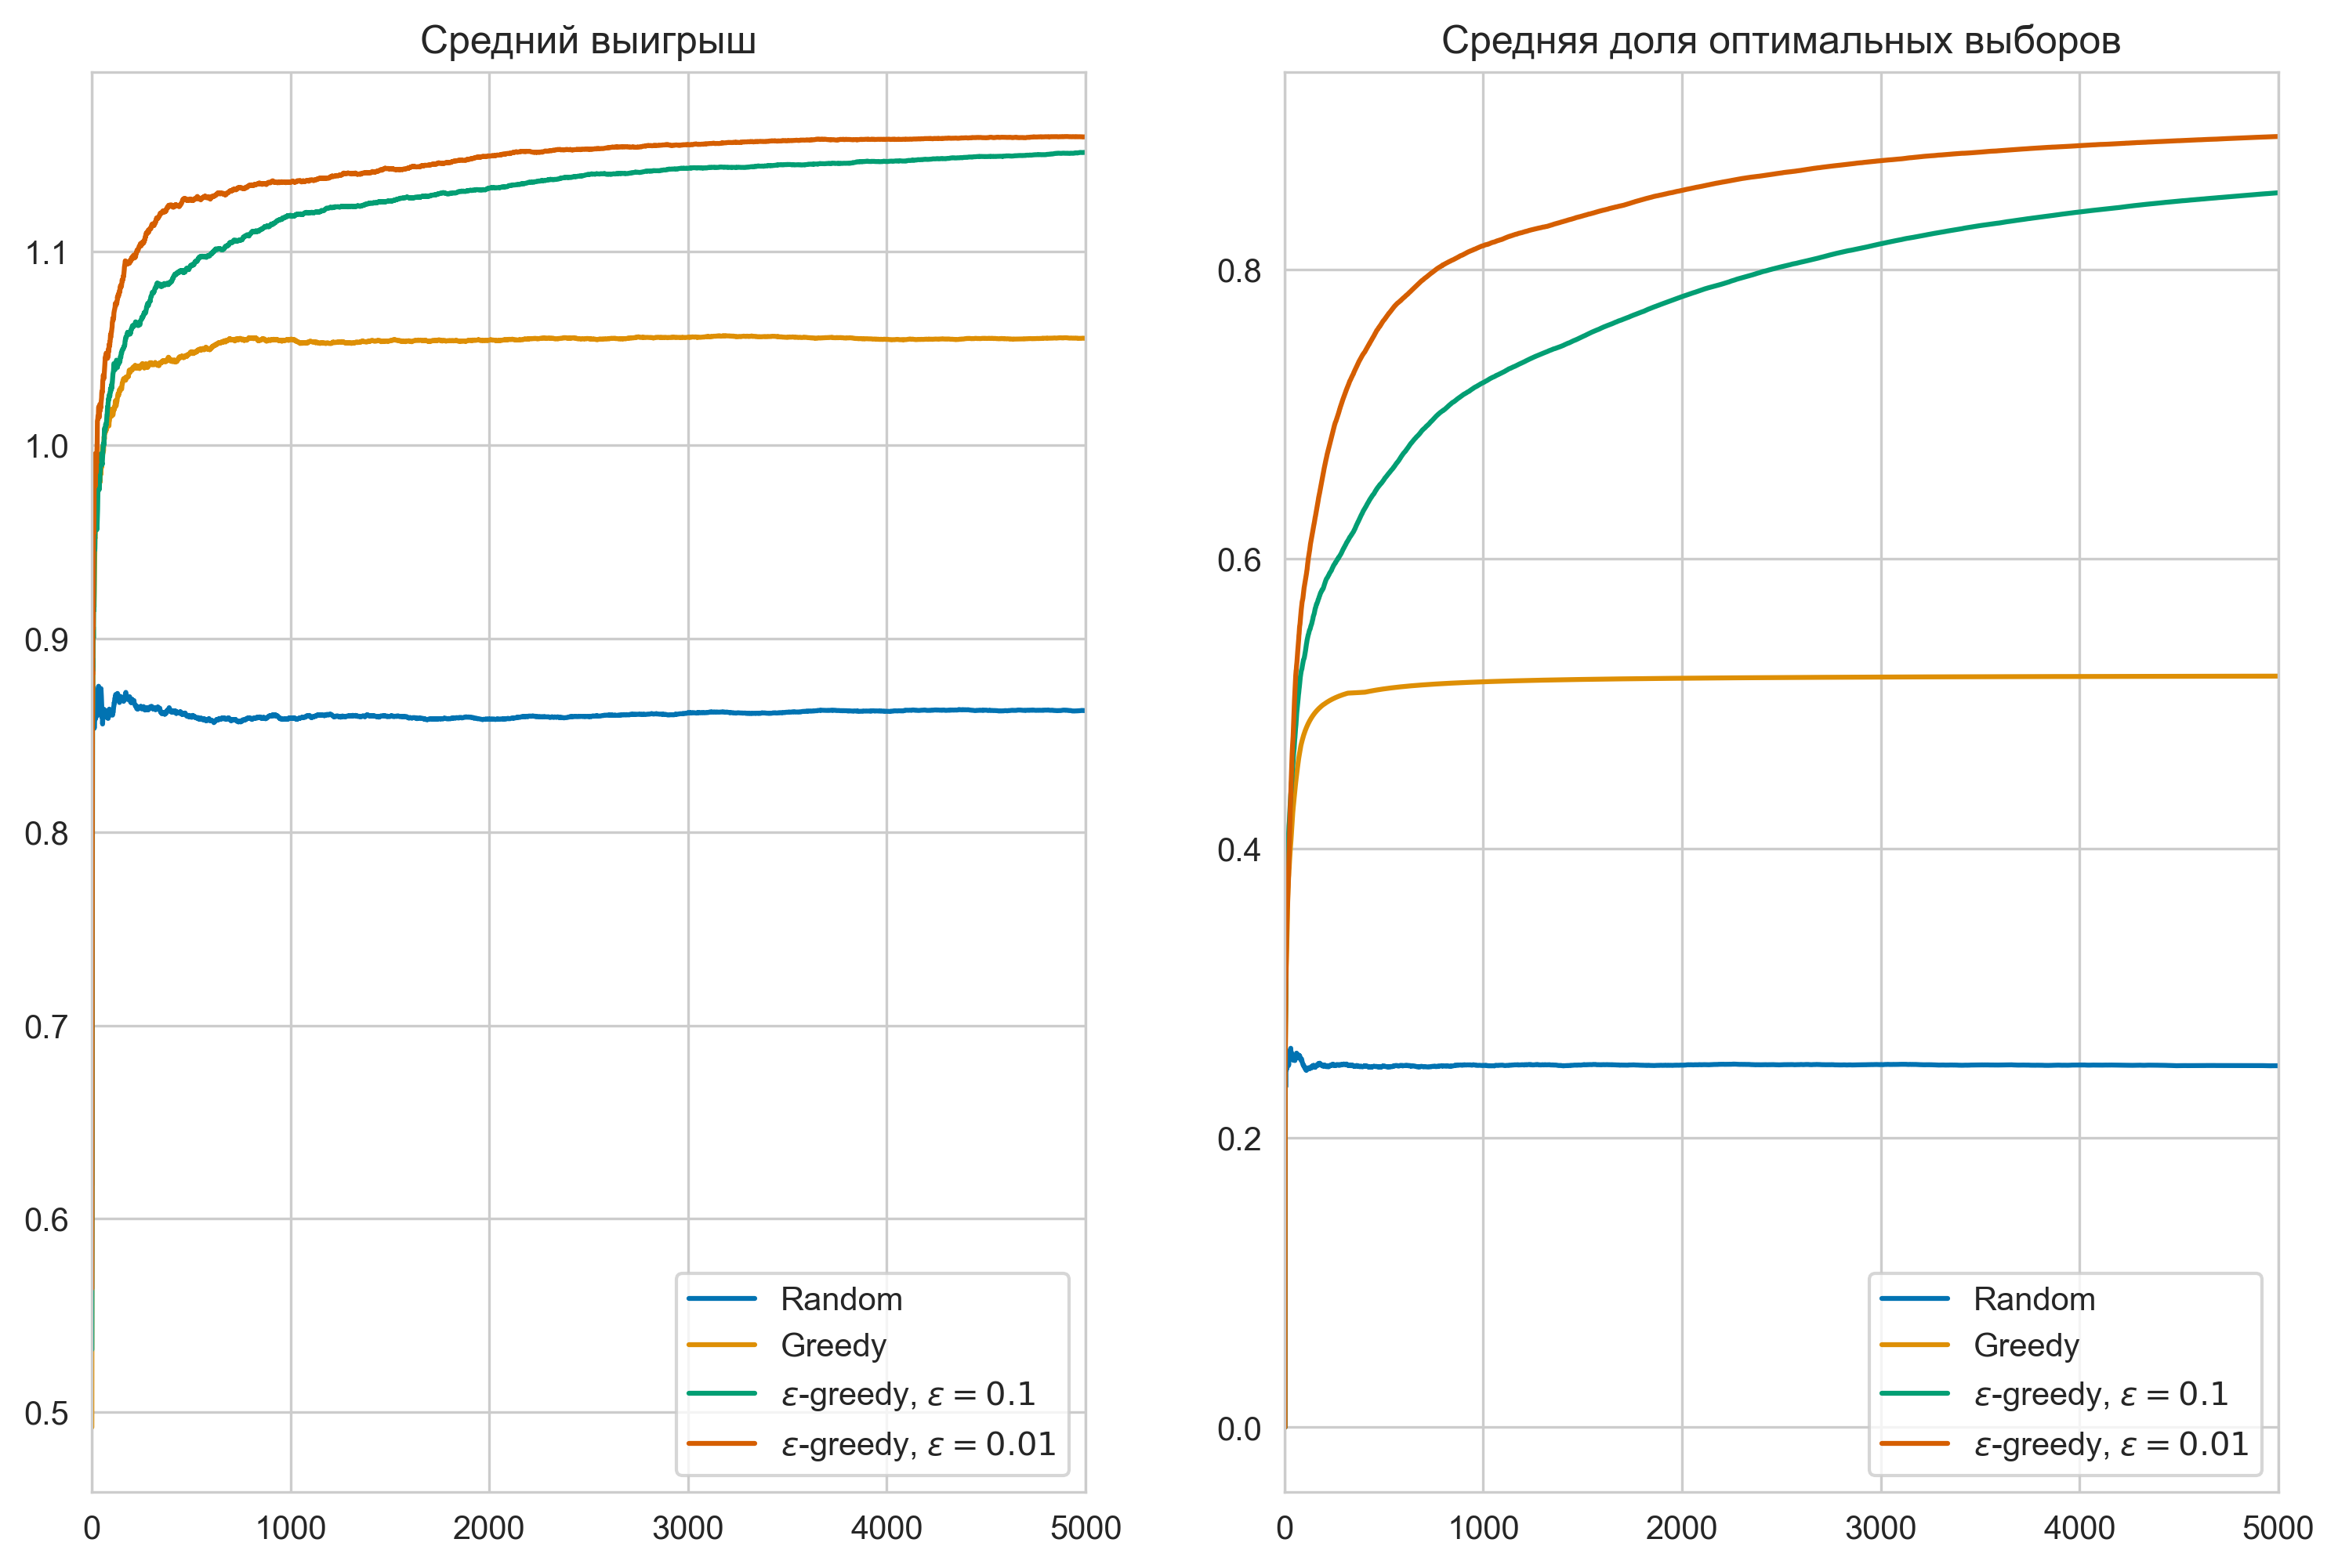

In [17]:
m_bandits = np.array([0.5, 0.75, 1.0, 1.2])
n_bandits = len(m_bandits)
best_arm = np.argmax(m_bandits)

n_random, n_greedy, n_epsgreedy, n_epsgreedy2 = 100, 100, 100, 100

bandits = [ Bandit(4, "Random") for _ in range(n_random) ] + \
          [ GreedyBandit(4, "Greedy") for _ in range(n_greedy) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.1$") for _ in range(n_epsgreedy) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.01$") for _ in range(n_epsgreedy2) ]

run_bandits(bandits, m_bandits, pull=pull_gauss_np, n_step=5000)
fig, axs = plot_average_over_bandits([
    bandits[:n_random],
    bandits[n_random:n_random+n_greedy],
    bandits[n_random+n_greedy:n_random+n_greedy+n_epsgreedy],
    bandits[n_random+n_greedy+n_epsgreedy:n_random+n_greedy+n_epsgreedy+n_epsgreedy2]
], best_arm, loc="lower right")

In [18]:
class UCB1Bandit(Bandit):
    def __init__(self, num, label, c=np.sqrt(2)):
        super().__init__(num, label)
        self.c = c

    def internal_next_arm(self):
        return np.argmax( np.true_divide( self.w, self.n ) + self.c * np.sqrt(np.array(np.log(len(self.hist)) / self.n)) )

Вероятности успеха: [0.3  0.6  0.55]


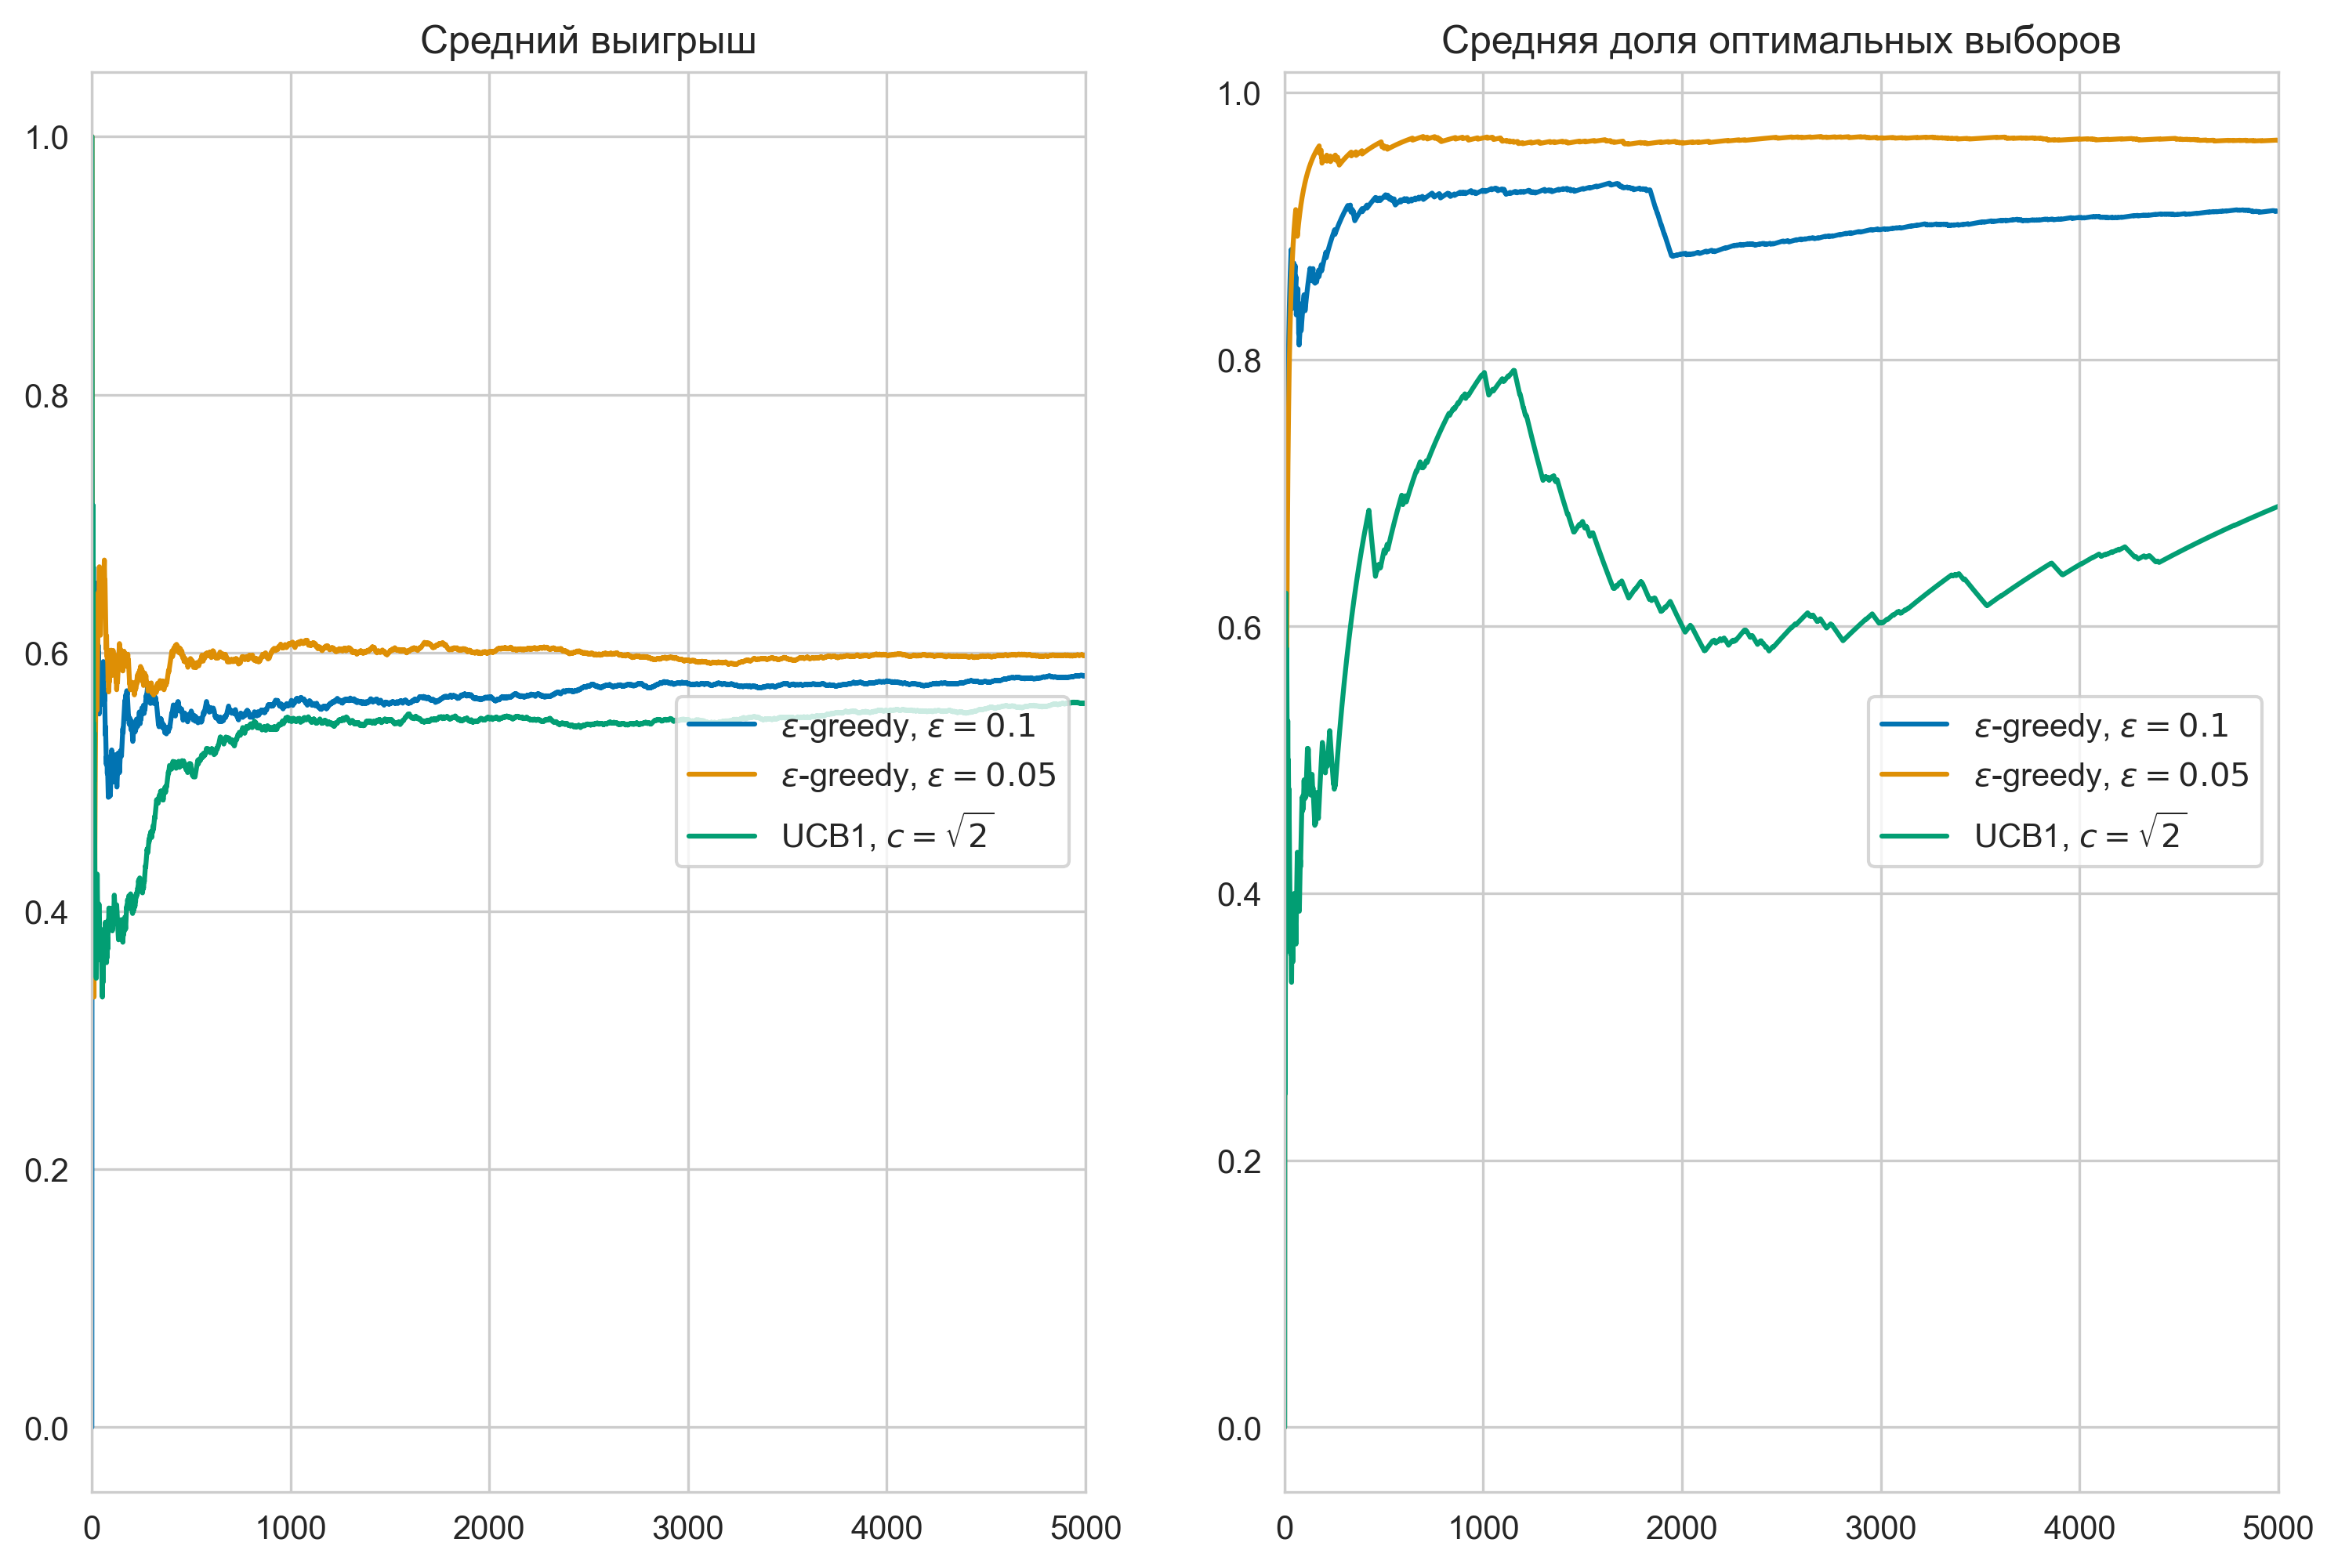

In [19]:
p_bandits = np.random.beta(1, 1, size=10)
best_arm = np.argmax(p_bandits)
n_bandits = len(p_bandits)

p_bandits = np.array([0.3, 0.6, 0.55])
n_bandits = len(p_bandits)
best_arm = np.argmax(p_bandits)
n_steps = 5000

print("Вероятности успеха: %s" % p_bandits)

bandits = [EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.1$", 0.1), EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.05$", 0.05), UCB1Bandit(n_bandits, "UCB1, $c=\\sqrt{2}$")]
run_bandits(bandits, p_bandits, n_step=n_steps)

fig, ax = plot_multiple_bandits(bandits, best_arm, loc="center right")

In [20]:
bandits[2].n

array([ 161, 3450, 1389])

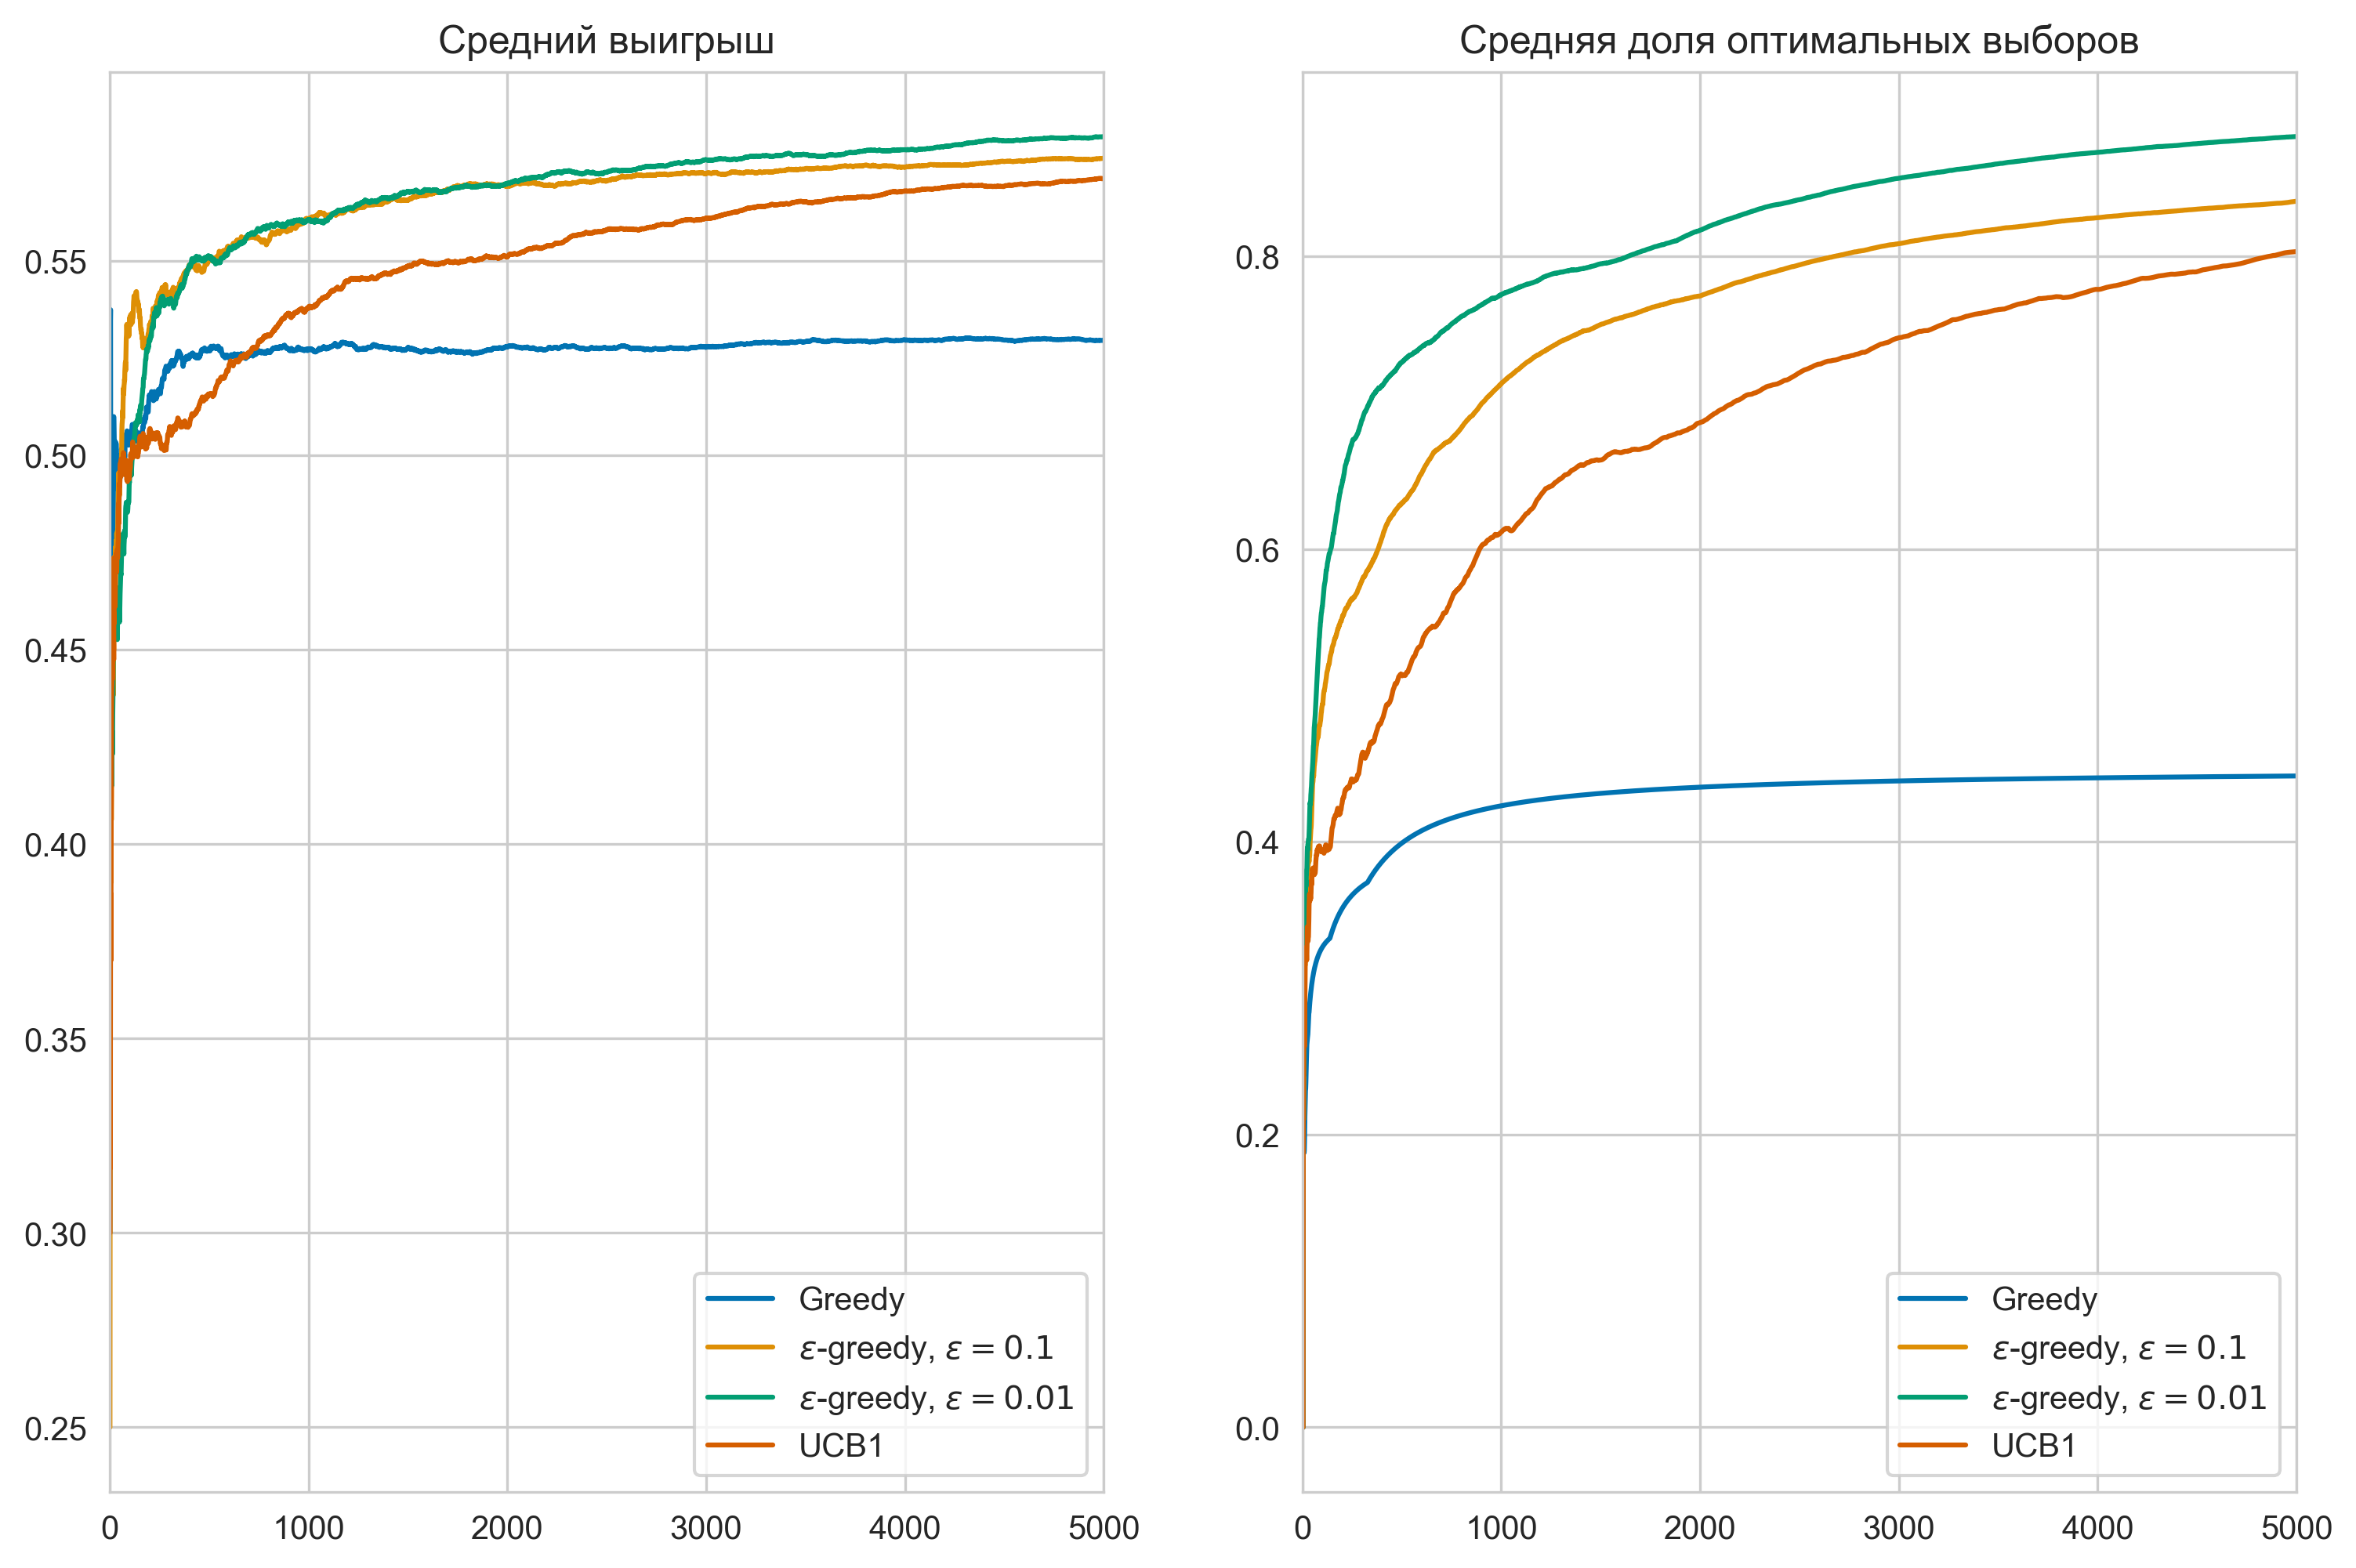

In [21]:
p_bandits = np.array([0.3, 0.4, 0.5, 0.6])
n_bandits = len(p_bandits)
best_arm = np.argmax(p_bandits)

n1, n2, n3, n4 = 20, 20, 20, 20

bandits = [ GreedyBandit(4, "Greedy") for _ in range(n1) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.1$") for _ in range(n2) ] + \
          [ EpsGreedyBandit(4, "$\\epsilon$-greedy, $\\epsilon=0.01$") for _ in range(n3) ] + \
          [ UCB1Bandit(4, "UCB1") for _ in range(n4) ]

run_bandits(bandits, p_bandits, n_step=5000)
fig, axs = plot_average_over_bandits([
    bandits[:n1],
    bandits[n1:n1+n2],
    bandits[n1+n2:n1+n2+n3],
    bandits[n1+n2+n3:n1+n2+n3+n4]
], best_arm, loc="lower right")

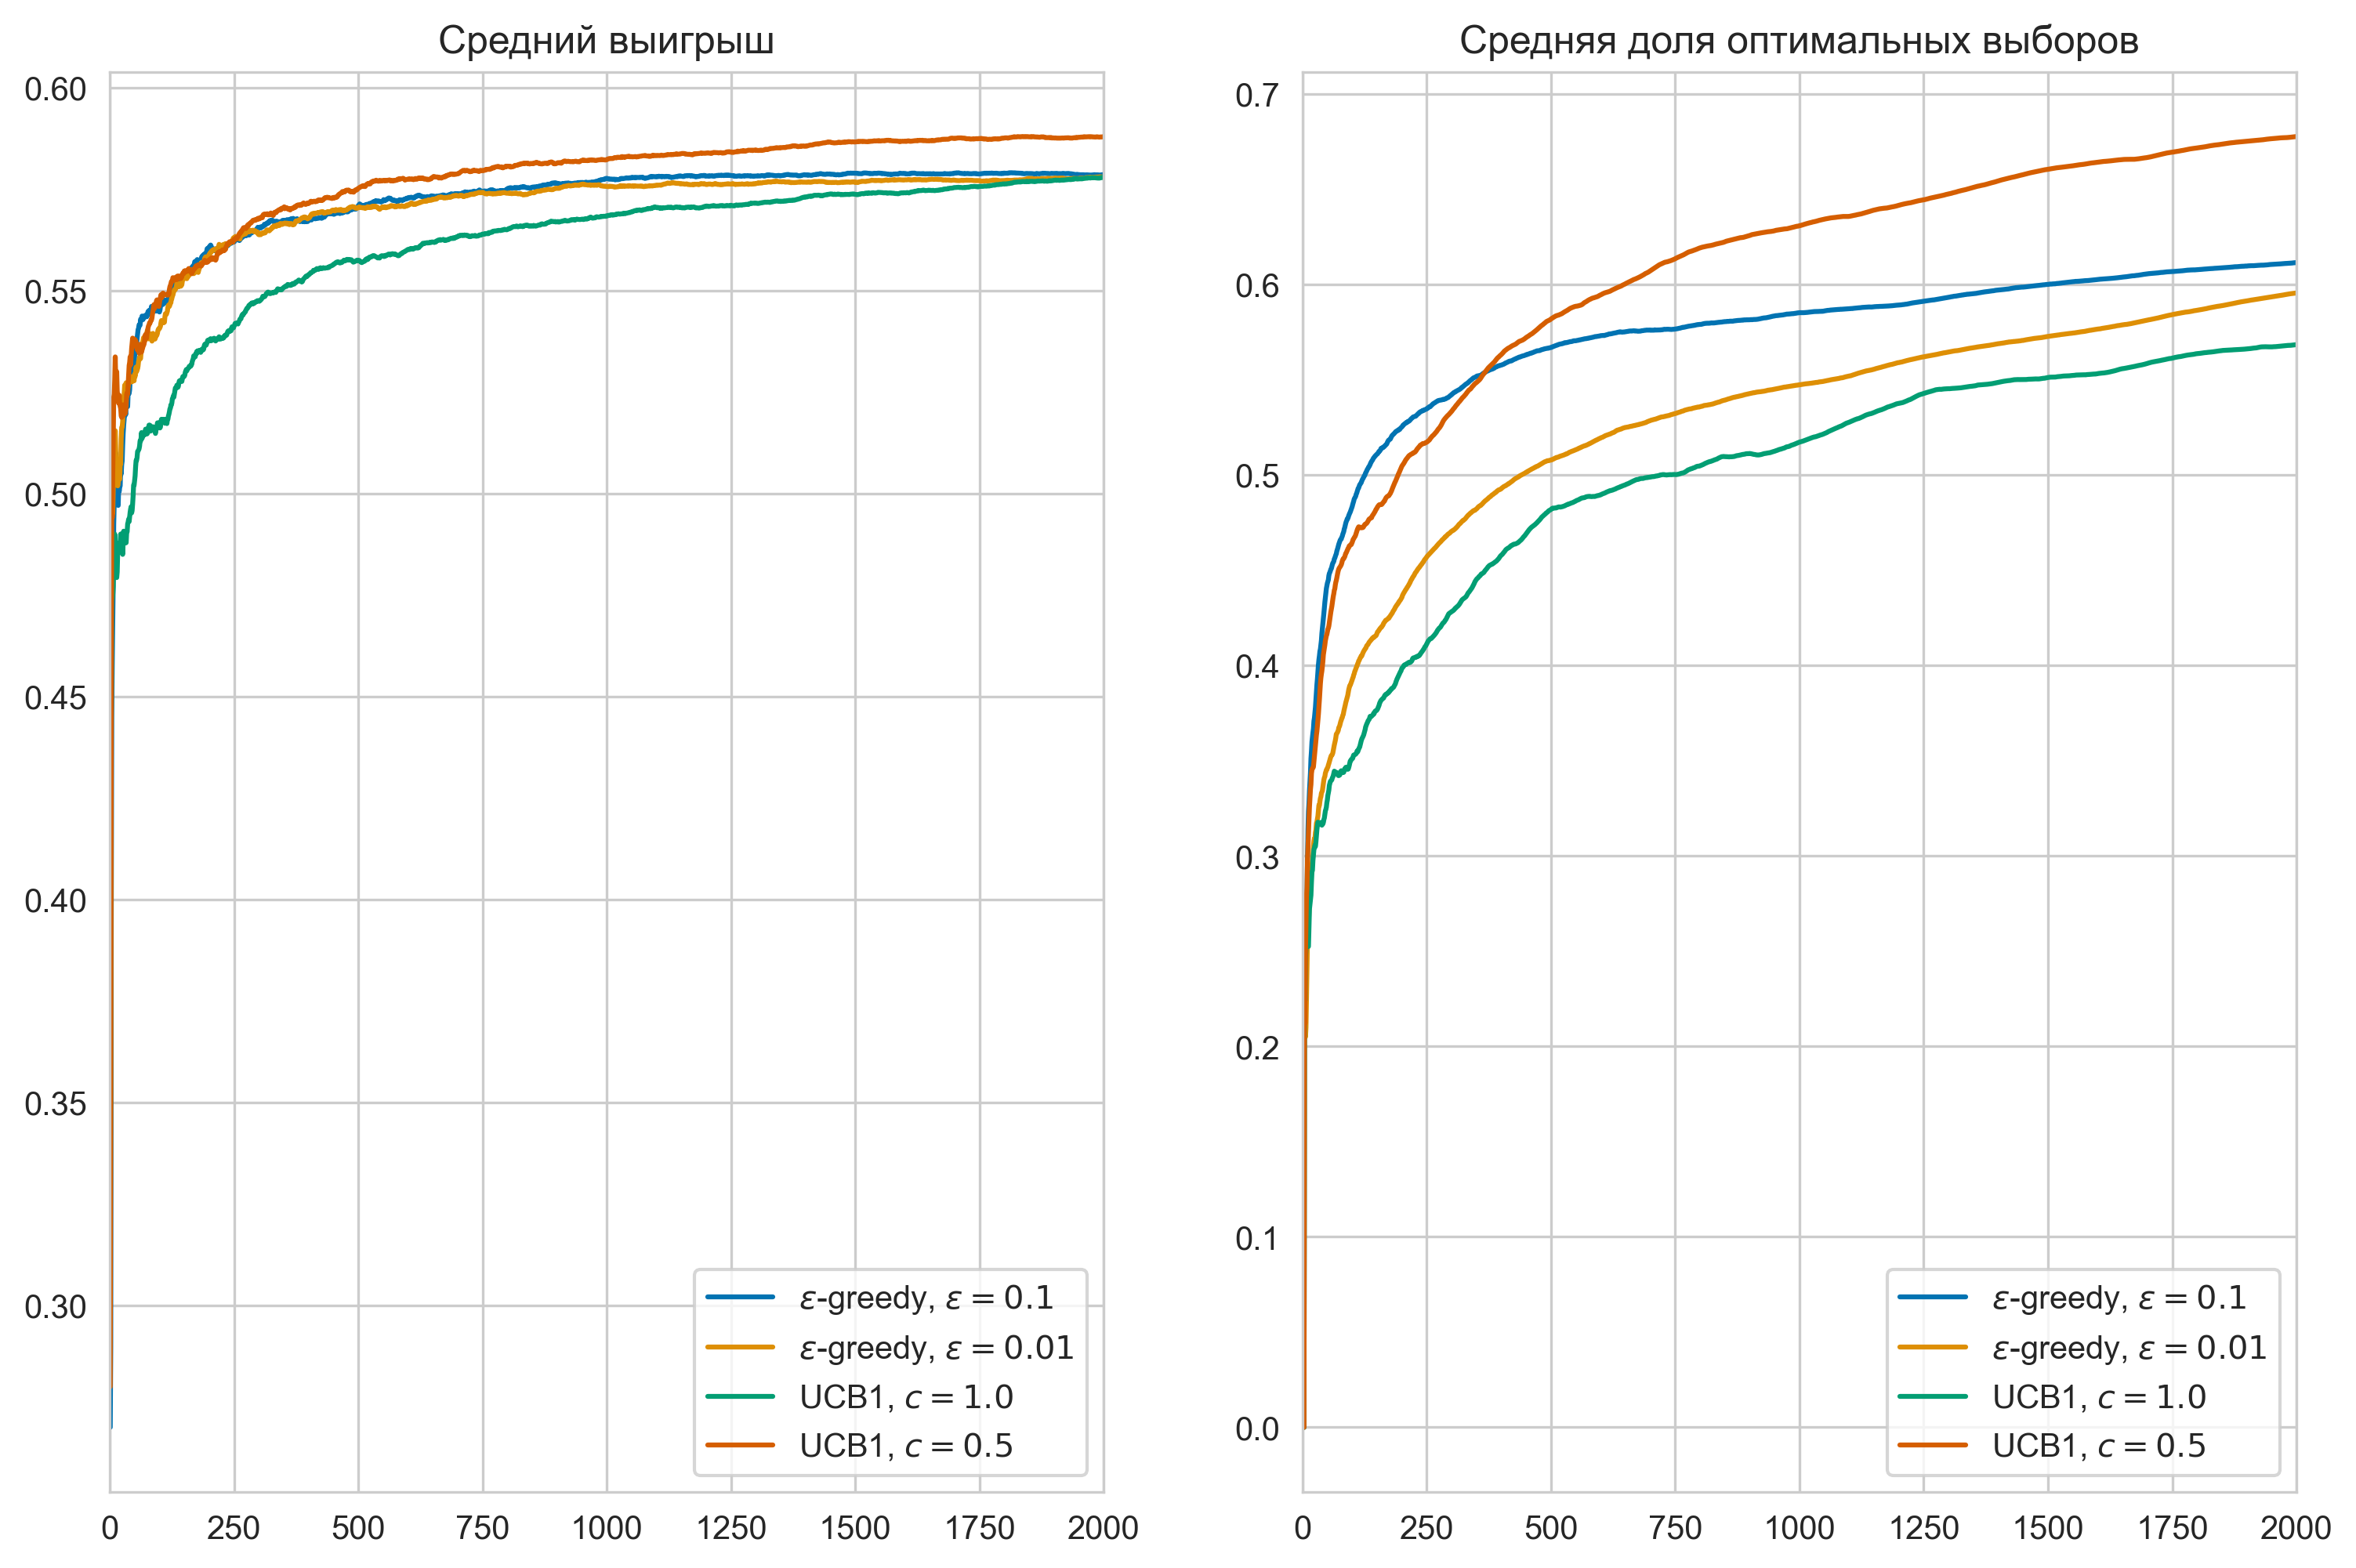

In [22]:
p_bandits = np.array([0.3, 0.4, 0.58, 0.6])
n_bandits = len(p_bandits)
best_arm = np.argmax(p_bandits)

n1, n2, n3, n4 = 100, 100, 100, 100

bandits = [ EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.1$") for _ in range(n1) ] + \
          [ EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.01$") for _ in range(n2) ] + \
          [ UCB1Bandit(n_bandits, "UCB1, $c=1.0$", c=1.0) for _ in range(n3) ] + \
          [ UCB1Bandit(n_bandits, "UCB1, $c=0.5$", c=0.5) for _ in range(n4) ]

run_bandits(bandits, p_bandits, n_step=2000)
fig, axs = plot_average_over_bandits([
    bandits[:n1],
    bandits[n1:n1+n2],
    bandits[n1+n2:n1+n2+n3],
    bandits[n1+n2+n3:n1+n2+n3+n4]
], best_arm, loc="lower right")

Средние ручек:
[ 1.2465725   0.99463856  0.71964313  0.50464034  0.10157752  1.84065956
 -0.50900015  1.65647331  0.05550022  0.06818942]


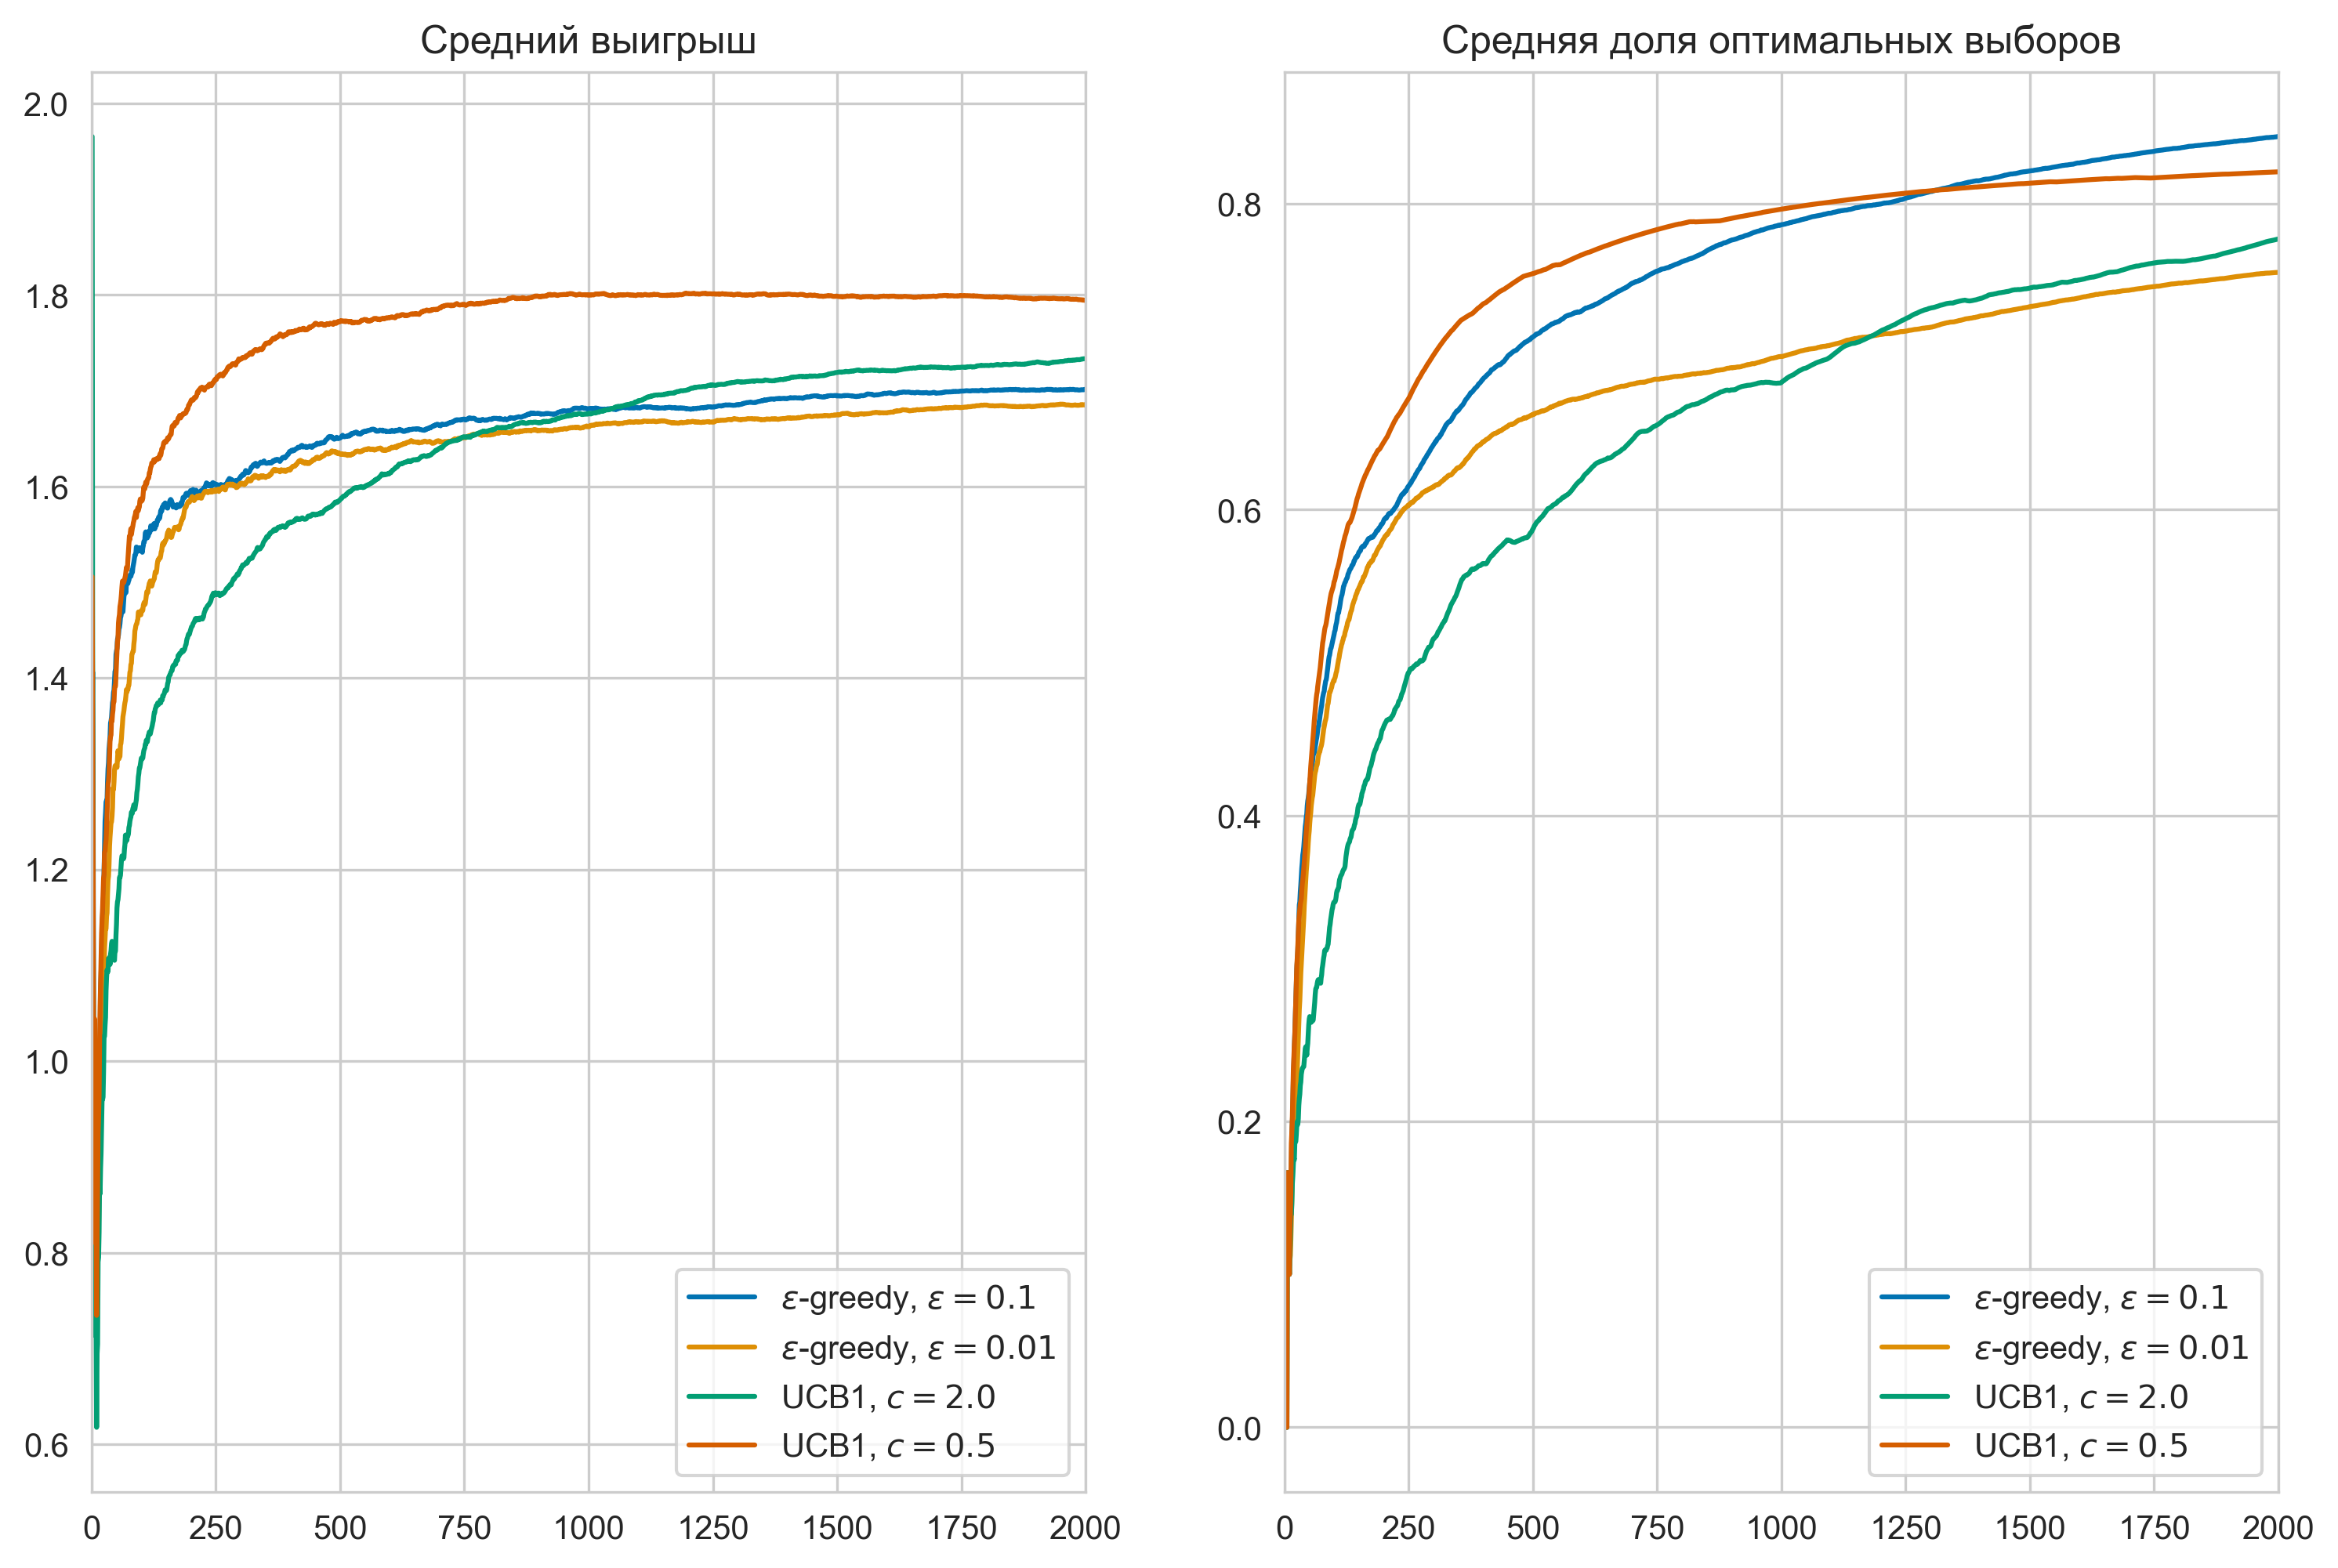

In [23]:
m_bandits = np.random.normal(loc=1.0, scale=1.0, size=10)
print("Средние ручек:\n%s" % m_bandits)
# np.array([0.5, 0.75, 1.0, 1.1])
n_bandits = len(m_bandits)
best_arm = np.argmax(m_bandits)

n1, n2, n3, n4 = 20, 20, 20, 20

bandits = [ EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.1$") for _ in range(n1) ] + \
          [ EpsGreedyBandit(n_bandits, "$\\epsilon$-greedy, $\\epsilon=0.01$") for _ in range(n2) ] + \
          [ UCB1Bandit(n_bandits, "UCB1, $c=2.0$", c=2.0) for _ in range(n3) ] + \
          [ UCB1Bandit(n_bandits, "UCB1, $c=0.5$", c=0.5) for _ in range(n4) ]

run_bandits(bandits, m_bandits, pull=pull_gauss_np, n_step=2000)
fig, axs = plot_average_over_bandits([
    bandits[:n1],
    bandits[n1:n1+n2],
    bandits[n1+n2:n1+n2+n3],
    bandits[n1+n2+n3:n1+n2+n3+n4]
], best_arm, loc="lower right")

In [24]:
bandits[0].w

array([ 2.87897975e+01,  2.18102687e+01,  9.93272074e+00,  6.23406992e+00,
       -2.96284642e-01,  3.36158625e+03, -8.01191943e+00,  3.66334255e+01,
       -1.52570898e+00,  2.47292622e+00])

## Thompson sampling

In [25]:
n_bandits = 3
p_bandits = [0.3, 0.55, 0.65]


plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 5000]

def plot_distributions(priors, step, ax, trials, wins):
    xs = np.linspace(0.001, .999, 100)
    for i, prior in enumerate(priors):
        y = prior.pdf(xs)
        p = ax.plot(xs, y, label="%d: %.4f %d/%d" % (i+1, prior.mean(), wins[i], trials[i]))
        ax.fill_between(xs, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper left")
    ax.set_title('Распределение на шаге %d' % step)

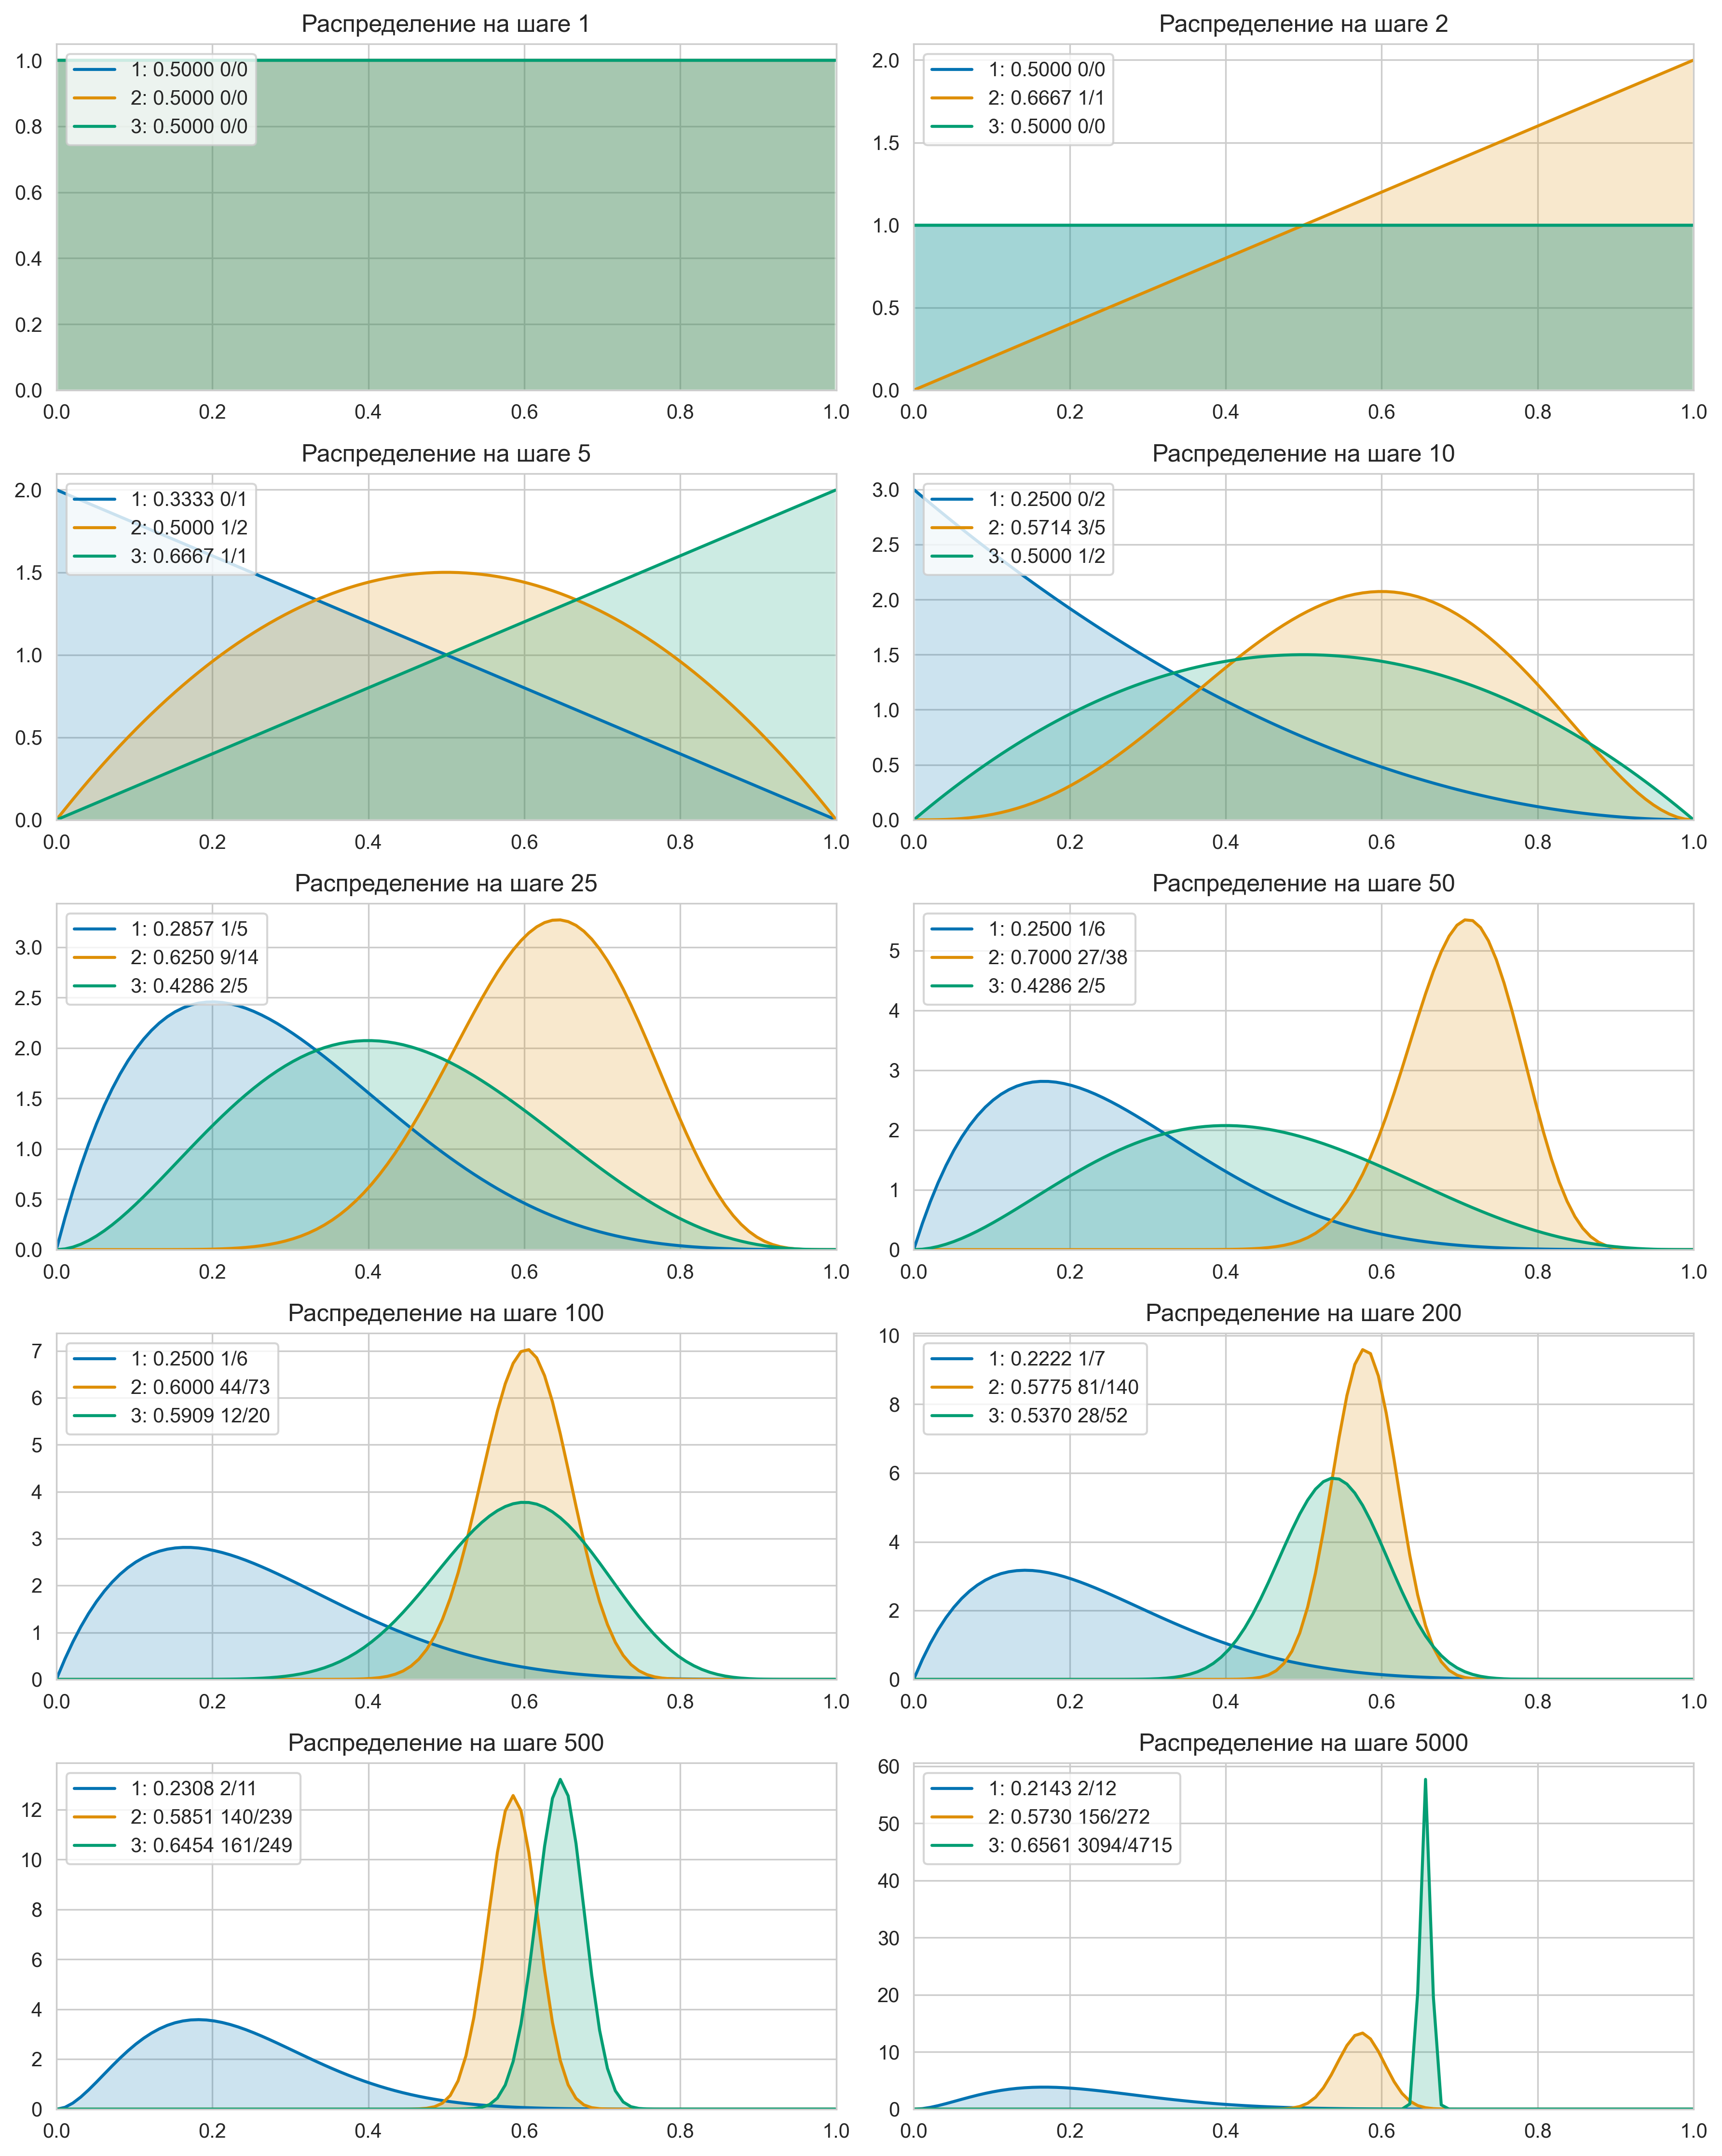

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
axs = axs.flat

trials = [0, 0, 0]
wins = [0, 0, 0]

n = 5000
for step in range(1, n+1):
    bandit_priors = [
        st.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    if step in plots:
        plot_distributions(bandit_priors, step, next(axs), trials, wins)
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    chosen_bandit = np.argmax(theta_samples)
    x = pull(chosen_bandit, p_bandits)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()